# 20220327-zoo
- Cumulative statistics (longest simpoint of each trace)
    - Accuracy
    - Coverage
    - IPC improvement (over no prefetcher)
    - MPKI reduction (over no prefetcher)
- Phase behavior (per-trace, across simpoints)
    - IPC
    - MPKI
    
- Collecting statistics (from `Pythia` directory):
    - Create Zoo sweep by running `./experiments/prefetcher_zoo.py condor_setup`
    - Evaluate Zoo sweep by running `./experiments/prefetcher_zoo.py eval`
    - If tuning prefetchers by degree:
        1. Create degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py condor_setup`
        2. Evaluate degree tuning sweep by running `./experiments/prefetcher_degree_sweep.py eval`
        3. Copy degree tuning ChampSim result files to the Zoo sweep ChampSim results directory
        4. Evaluate combined sweep by running `./experiments/prefetcher_zoo.py eval --best-degree-csv <output of (2)>`

In [75]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

In [76]:
data_path = '/u/cmolder/GitHub/Pythia/out/prefetcher_zoo.csv'
weight_path = '/scratch/cluster/cmolder/traces/prefetcher_zoo/champsim/weights.txt'

gap = ['cc', 'pr', 'sssp', 'bfs', 'tc']
spec = ['astar', 'bwaves', 'bzip2', 'cactusADM', 'calculix',
        'gcc', 'GemsFDTD', 'hmmer', 'lbm', 'leslie3d',
        'libquantum', 'mcf', 'milc', 'omnetpp', 'soplex',
        'sphinx3', 'tonto', 'wrf', 'xalancbmk']

# def prefetcher_name(pref):
#     pref = pref.replace('scooby', 'pythia').replace('spp_dev2', 'spp')
#     return pref

df = pd.read_csv(data_path)
df.prefetcher = df.prefetcher.replace({
    'scooby': 'pythia',
    'spp_dev2': 'spp',
    'bop': 'bo'
}, regex=True)
print(df.prefetcher)

0           bingo_bo
1              bingo
2       bingo_pythia
3         bingo_sisb
4          bingo_sms
            ...     
1297        sms_sisb
1298         sms_spp
1299             spp
1300      spp_pythia
1301        spp_sisb
Name: prefetcher, Length: 1302, dtype: object


In [77]:
weights = pd.read_csv(weight_path, sep=' ', header=None)
weights.columns = ['trace', 'weight']
weights

,trace,weight
0,astar_163B,0.452174
1,astar_23B,0.162319
2,astar_313B,0.220290
3,bwaves_1609B,0.262524
4,bwaves_1861B,0.337187
...,...,...
64,cc,1.000000
65,pr,1.000000
66,bfs,1.000000
67,sssp,1.000000


# Helper functions

In [78]:
def get_longest_simpoints(weights):
    weights_ = weights.copy()
    trace_tokens = weights.trace.str.split(pat='_', expand=True)

    weights_['trace_name'] = trace_tokens[0]
    weights_['simpoint'] = trace_tokens[1]
    
    idx = (weights_.groupby('trace_name')['weight'].transform(max) == weights_['weight'])
    traces = weights[idx].trace
    return traces

def get_weighted_statistics(df, weights, metric, add_phase_combined=True):
    weights_ = weights.copy()
    trace_tokens = weights.trace.str.split(pat='_', expand=True)

    weights_['trace_name'] = trace_tokens[0]
    weights_['simpoint'] = trace_tokens[1]
    
    stats = {
        'trace': np.array([]),
        'prefetcher': np.array([]),
        'simpoint': np.array([]),
        'accuracy': np.array([]),
        'coverage': np.array([]),
        'ipc_improvement': np.array([]),
        'mpki_reduction': np.array([]),
    }
    
    metrics = ['accuracy', 'coverage', 'ipc_improvement', 'mpki_reduction']
    
    traces = df.trace.unique()
    for tr in traces:
        wt = weights_[weights_.trace_name == tr][['simpoint', 'weight']]
        for pf in df.prefetcher.unique():
            data = df[(df.trace == tr) & (df.prefetcher == pf)]
            data = data.merge(wt, on='simpoint')
            weights = data['weight'] / sum(data['weight'])
            
            stats['trace'] = np.append(stats['trace'], tr)
            stats['prefetcher'] = np.append(stats['prefetcher'], pf)
            stats['simpoint'] = np.append(stats['simpoint'], 'weighted')

            for metric in metrics:
                mean_metric = 'amean' if metric in ['accuracy', 'coverage'] else 'gmean' 
                
                if len(data) <= 1:
                    target = data[metric].item()
                else:
                    target = mean(data[metric], weights=weights, metric=metric, by=mean_metric)
                stats[f'{metric}'] = np.append(stats[f'{metric}'], target)
                    
        if add_phase_combined:
            data = df[(df.trace == tr)]
            data.simpoint.fillna('default', inplace=True) # For one-simpoint traces
            wt.simpoint.fillna('default', inplace=True) # For one-simpoint traces
            
            stats['trace'] = np.append(stats['trace'], tr)
            stats['prefetcher'] = np.append(stats['prefetcher'], 'phase_combined')
            stats['simpoint'] = np.append(stats['simpoint'], 'weighted')            
            for metric in metrics:
                mean_metric = 'amean' if metric in ['accuracy', 'coverage'] else 'gmean' 
                
                best_metrics = data.groupby('simpoint')[metric].max().to_frame()
                best_metrics = best_metrics.merge(wt, on='simpoint')
                best_metrics['weight'] = best_metrics['weight'] / best_metrics['weight'].sum()
                
                target = mean(best_metrics[metric], weights=best_metrics['weight'], metric=metric, by=mean_metric)
                stats[f'{metric}'] = np.append(stats[f'{metric}'], target)
               
    return pd.DataFrame(stats)


def get_best_prefetchers(df, filter_by, filter_count):
    mean_metric = 'amean' if filter_by in ['accuracy', 'coverage'] else 'gmean'
    pf_avgs = []
    for i, (pf, df_pf) in enumerate(df.groupby('prefetcher')):
        avg = mean(df_pf[filter_by], by=mean_metric)
        pf_avgs.append((avg, pf))
        
    best = sorted(pf_avgs)[::-1][:filter_count]
    return [pf for _, pf in best]
        


def mean(values, by='amean', metric='ipc_improvement', weights=None):
    if type(weights) is np.ndarray:
        assert np.isclose(np.sum(weights), 1), 'Weights should sum to 1'
    if by == 'amean':
        return np.average(values, weights=weights)
    else:
        if metric == 'ipc_improvement':
            # Add 100 to prevent negative values (so that 100 = no prefetcher baseline)
            return stats.gmean(values + 100, weights=weights) - 100 
        if metric == 'mpki_reduction':
            # Take gmean of relative misses instead of MPKI reduction to prevent negative values
            return 100 - stats.gmean(100 - values, weights=weights) 

# Cumulative statistics
- Compare prefetchers on the longest simpoint of each trace

In [131]:
def plot_cumulative_statistics(df, weights, metric='accuracy', method='longest',
                               filter_by='ipc_improvement',
                               filter_method='longest',
                               filter_count=10,
                               filter_benchmarks=None,
                               dpi=192,
                               ymin=None, ymax=None):
    
    # Filter benchmarks (if wanted)
    if filter_benchmarks is not None:
        df = df[df.trace.isin(filter_benchmarks)]

    # Filter prefetchers (if wanted)
    if filter_by is not None:
        if filter_method == 'longest': # Filter by longest simpoint
            df_ = df[df.full_trace.isin(get_longest_simpoints(weights))] 
        else: # Filter by Weighted simpoints
            df_ = get_weighted_statistics(df, weights, filter_by, add_phase_combined=False)   
        best_prefetchers = get_best_prefetchers(df_, filter_by, filter_count)
        best_prefetchers += ['phase_combined'] if method == 'weighted' else []
        
        df = df[df.prefetcher.isin(best_prefetchers)]
        
    # Filter or weight simpoints  
    if method == 'weighted':
        df = get_weighted_statistics(df, weights, metric, add_phase_combined=True) # Weighted simpoints
    else:
        df = df[df.full_trace.isin(get_longest_simpoints(weights))] # Longest simpoint
    
    # Plot
    traces = df['trace'].unique()
    num_prefetchers = len(df.groupby('prefetcher'))
    num_traces = len(df.groupby('trace'))
    mean_metric = 'amean' if metric in ['accuracy', 'coverage'] else 'gmean'
    sep = 3
    
    fig, ax = plt.subplots(figsize=(12, 6), dpi=dpi)
    ax.grid(axis='y', color='lightgray')
    ax.axhline(0, color='black')
    ax.set_axisbelow(True)
        
    pf_list = best_prefetchers if filter_by is not None else df.prefetcher.unique()
    for i, pf in enumerate(pf_list):
        df_pf = df[df.prefetcher == pf]
        y = df_pf[metric].to_numpy()
        y = np.append(y, mean(y, metric=metric, by=mean_metric))
        X = np.arange(0, len(y)) * (num_prefetchers + sep) + i
        label = f'({best_prefetchers.index(pf)+1}) {pf}' if filter_by is not None and pf != 'phase_combined' else pf
        color = 'blue' if pf == 'phase_combined' else None
        ax.bar(X, y, label=label, color=color)
        
    
    ax.set_xticks(np.arange(0, len(traces) + 1) * (num_prefetchers + sep) + (num_prefetchers)/2)
    ax.set_xticklabels(traces.tolist() + [mean_metric], rotation=45)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    
    fig.suptitle(f'{metric} ({method} simpoint)')
    ax.set_xlabel('Trace')
    ax.set_ylabel(metric)
    ax.set_ylim(ymin=ymin, ymax=ymax) 
    fig.tight_layout()

---
## SPEC '06 cumulative statistics
### Longest simpoint

In [132]:
# plot_cumulative_statistics(df, weights, metric='accuracy', 
#                            ymin=0, ymax=100, dpi=120, 
#                            filter_benchmarks=spec)

In [133]:
# plot_cumulative_statistics(df, weights, metric='coverage',
#                            ymin=0, ymax=100, dpi=120, 
#                            filter_benchmarks=spec)

In [134]:
# plot_cumulative_statistics(df, weights, metric='mpki_reduction',
#                            ymin=0, ymax=100, dpi=120, 
#                            filter_benchmarks=spec)

In [135]:
# plot_cumulative_statistics(df, weights, metric='ipc_improvement',
#                            ymin=-40, ymax=120, dpi=120, 
#                            filter_benchmarks=spec)

### Weighted simpoint, top 10

/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


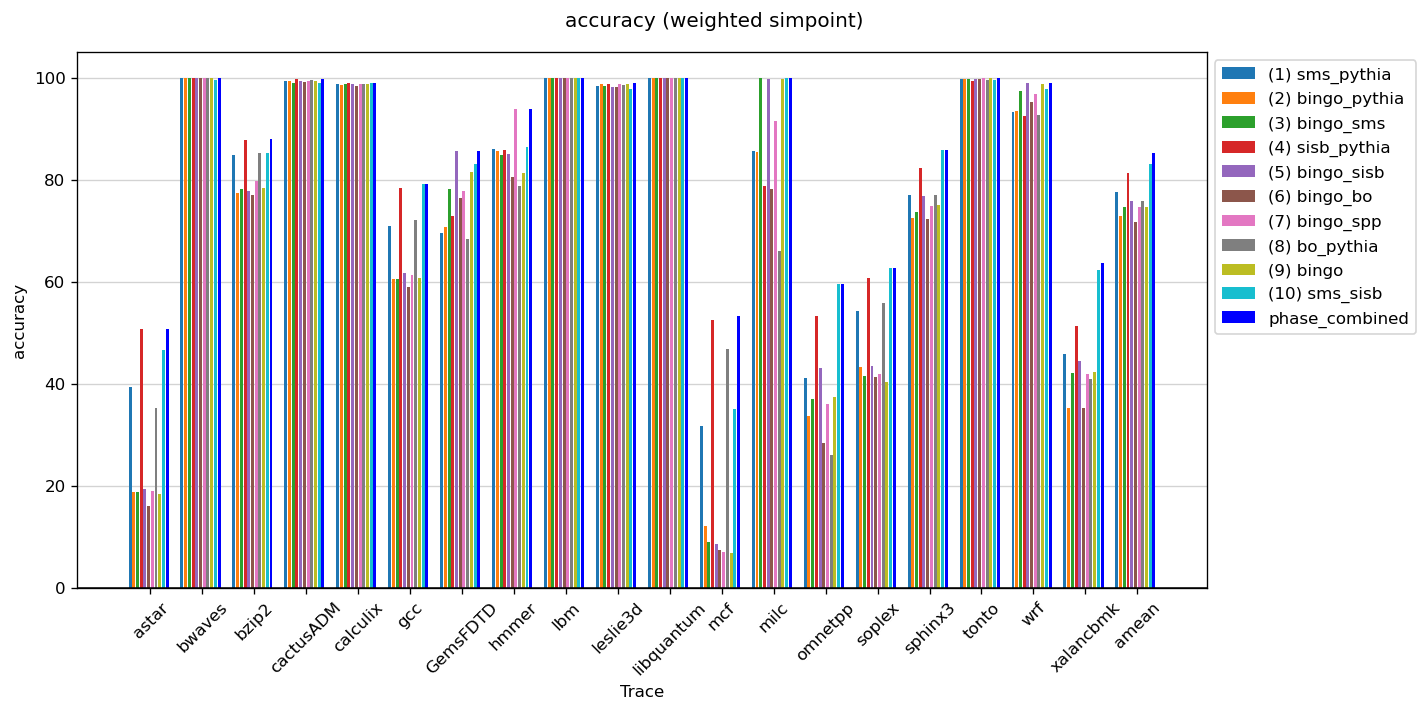

In [136]:
# TODO: Fix accuracy error in amean
plot_cumulative_statistics(df, weights, metric='accuracy', method='weighted',
                           ymin=0, ymax=105, dpi=120, 
                           filter_benchmarks=spec)

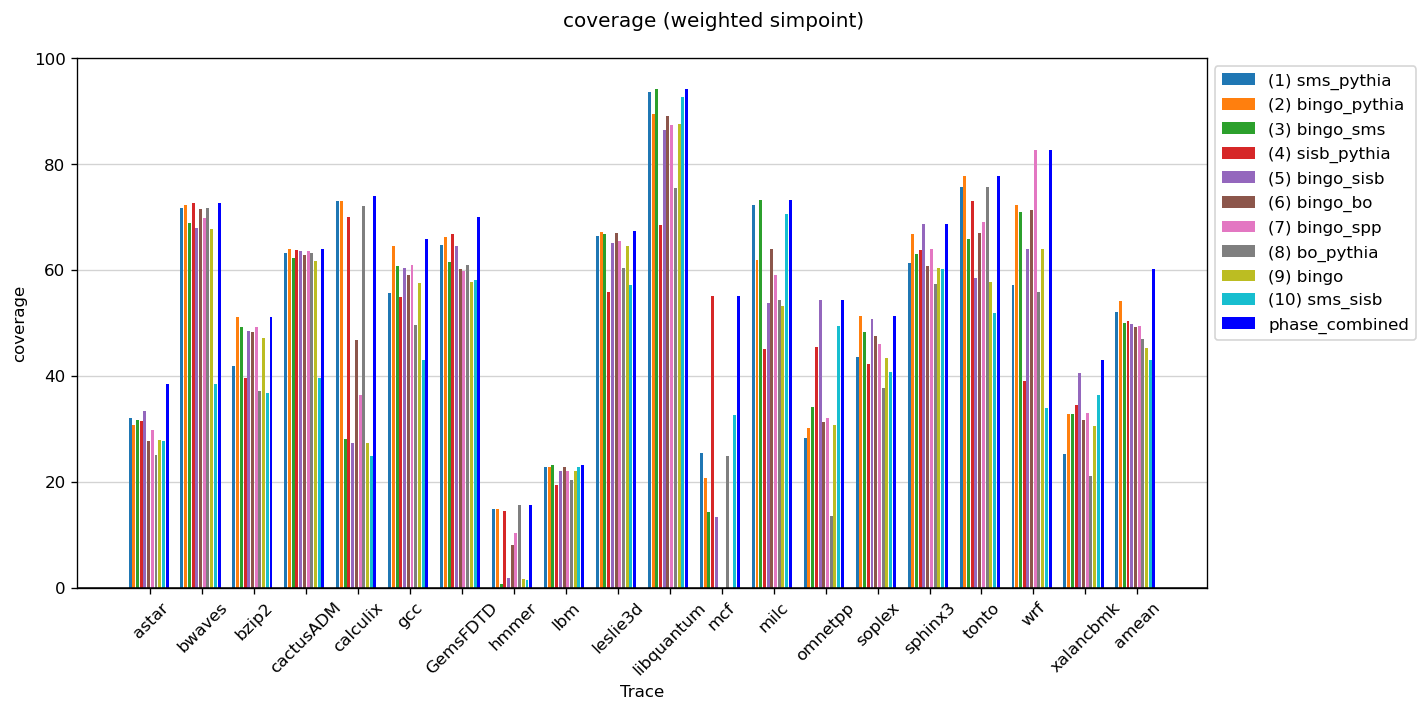

In [137]:
plot_cumulative_statistics(df, weights, metric='coverage', method='weighted',
                           ymin=0, ymax=100, dpi=120, 
                           filter_benchmarks=spec)

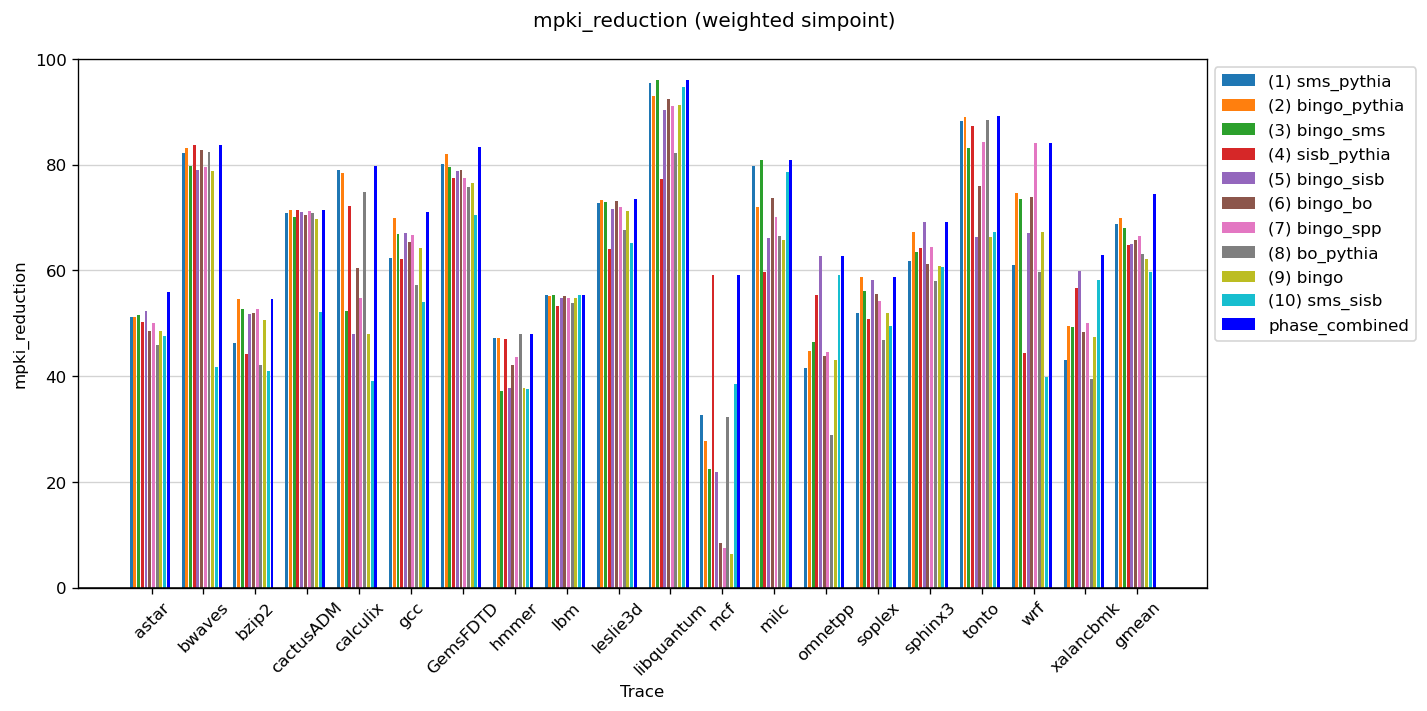

In [138]:
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='weighted',
                           ymin=0, ymax=100, dpi=120, 
                           filter_benchmarks=spec)

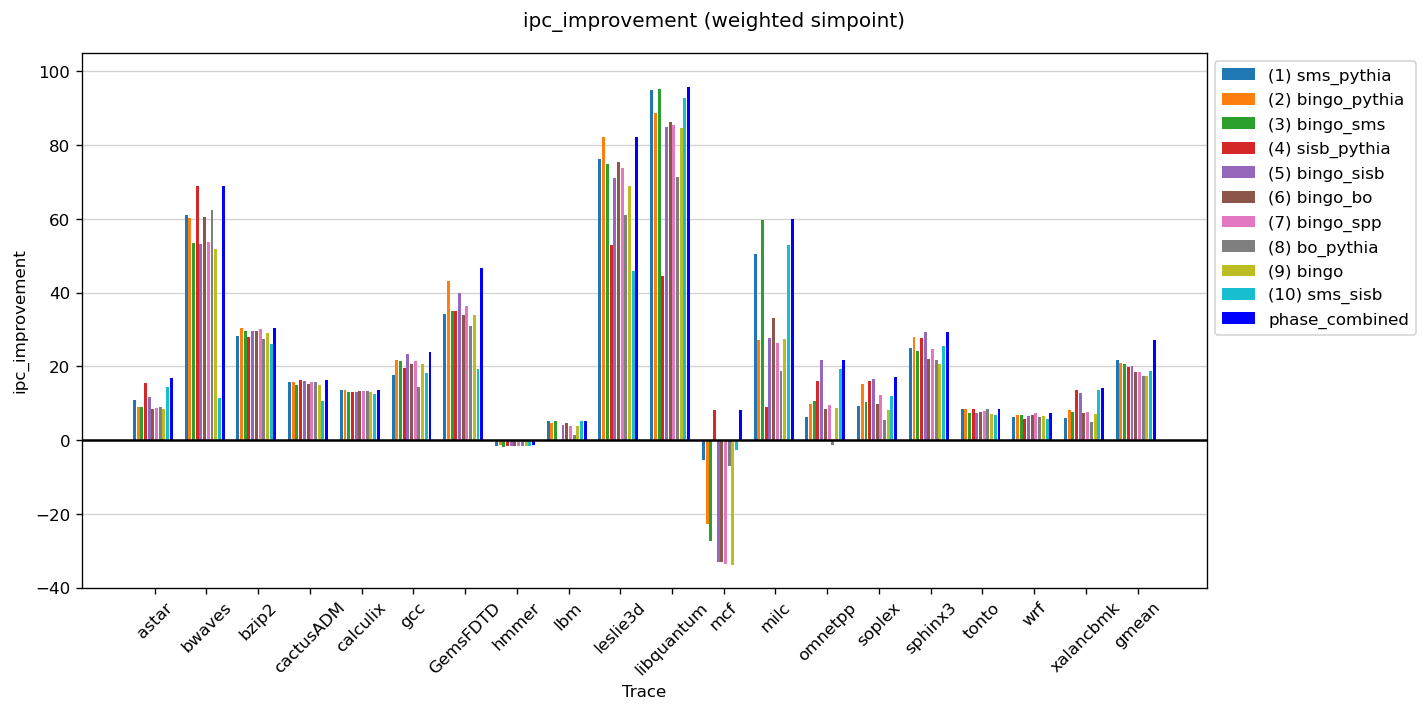

In [139]:
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                           ymin=-40, ymax=105, dpi=120, 
                           filter_benchmarks=spec)

### Weighted simpoint, top 5

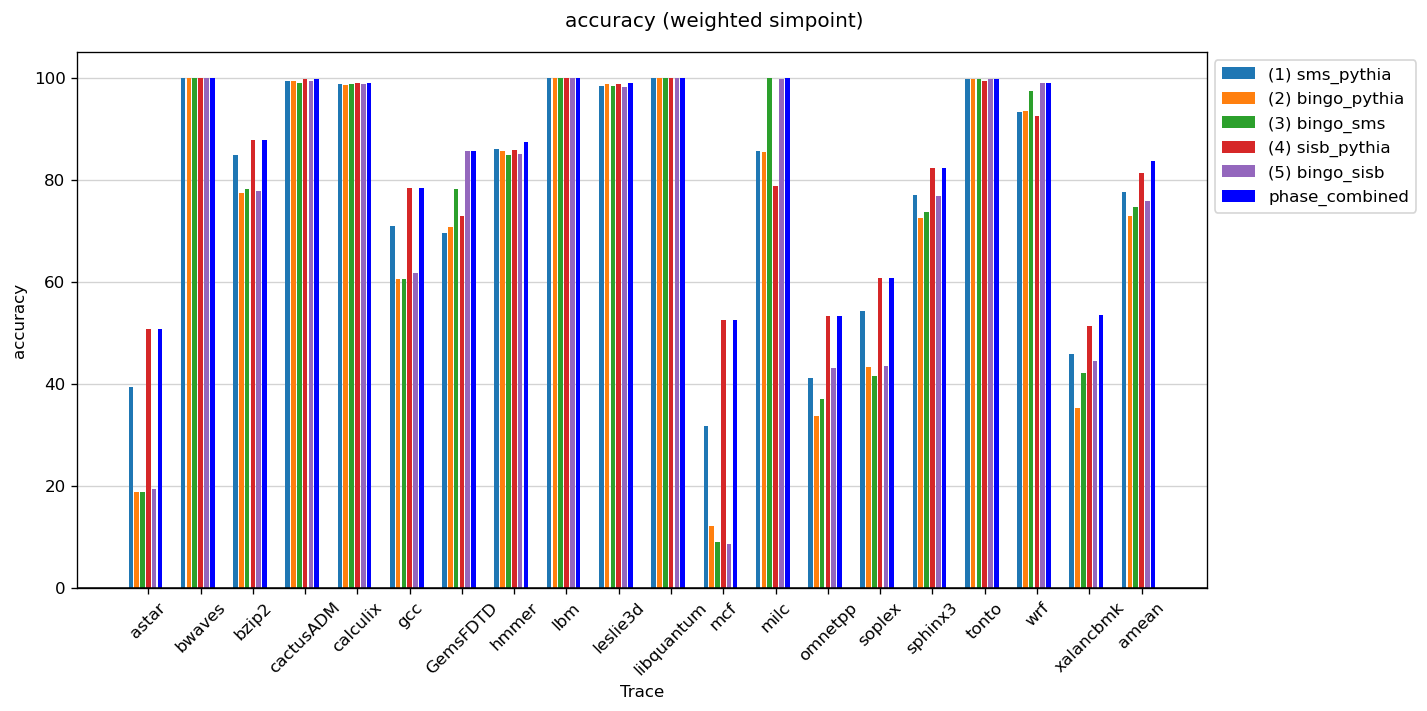

In [140]:
plot_cumulative_statistics(df, weights, metric='accuracy', method='weighted',
                           ymin=0, ymax=105, dpi=120,
                           filter_count=5,
                           filter_benchmarks=spec)
plt.savefig('accuracy_5_spec.pdf')

/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


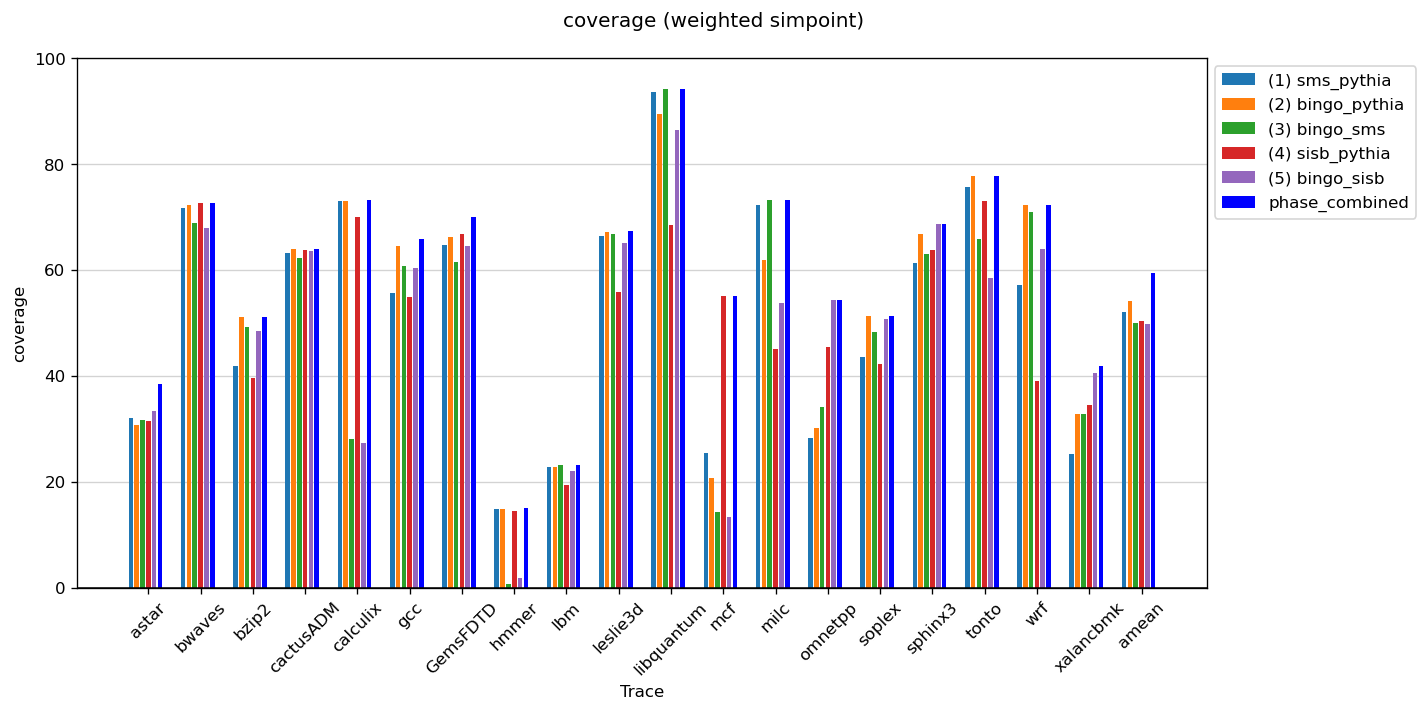

In [141]:
plot_cumulative_statistics(df, weights, metric='coverage', method='weighted',
                           ymin=0, ymax=100, dpi=120,
                           filter_count=5,
                           filter_benchmarks=spec)
plt.savefig('coverage_5_spec.pdf')

/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


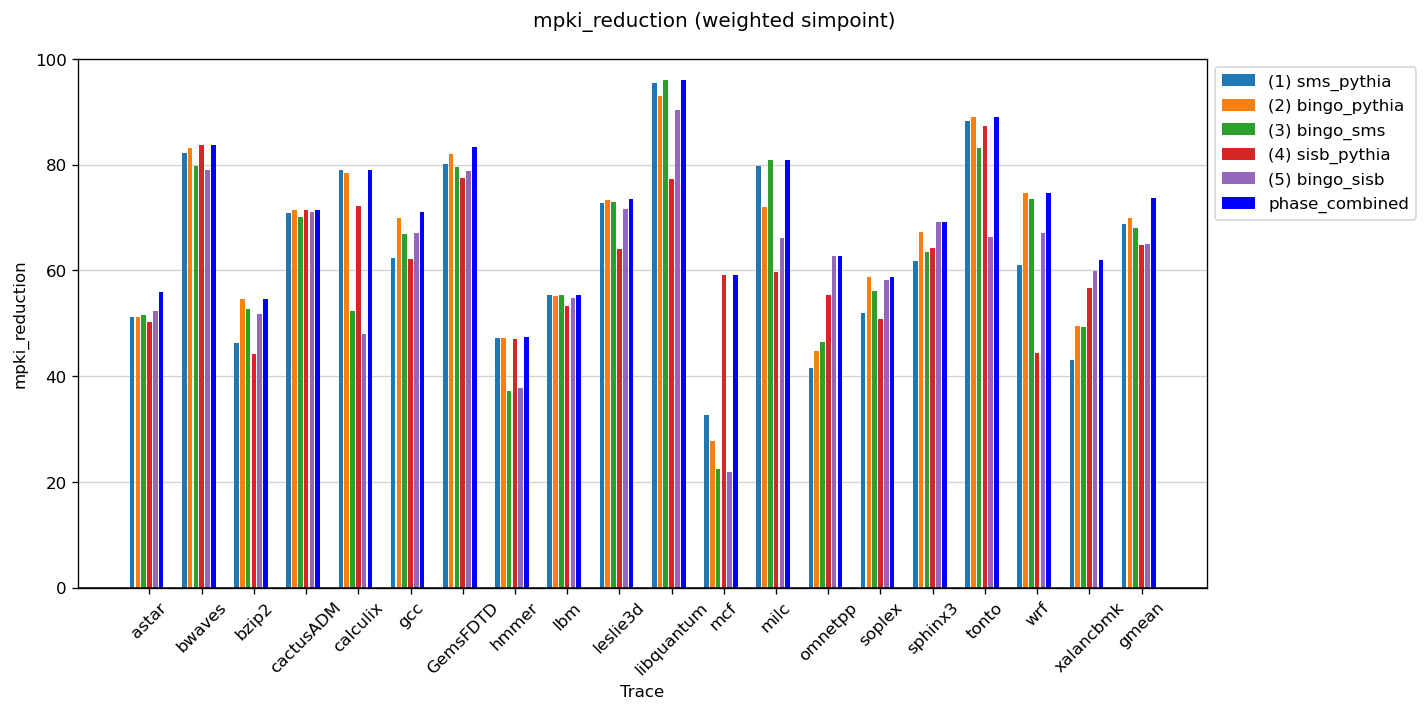

In [142]:
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='weighted',
                           ymin=0, ymax=100, dpi=120,
                           filter_count=5,
                           filter_benchmarks=spec)
plt.savefig('mpki_reduction_5_spec.pdf')

/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


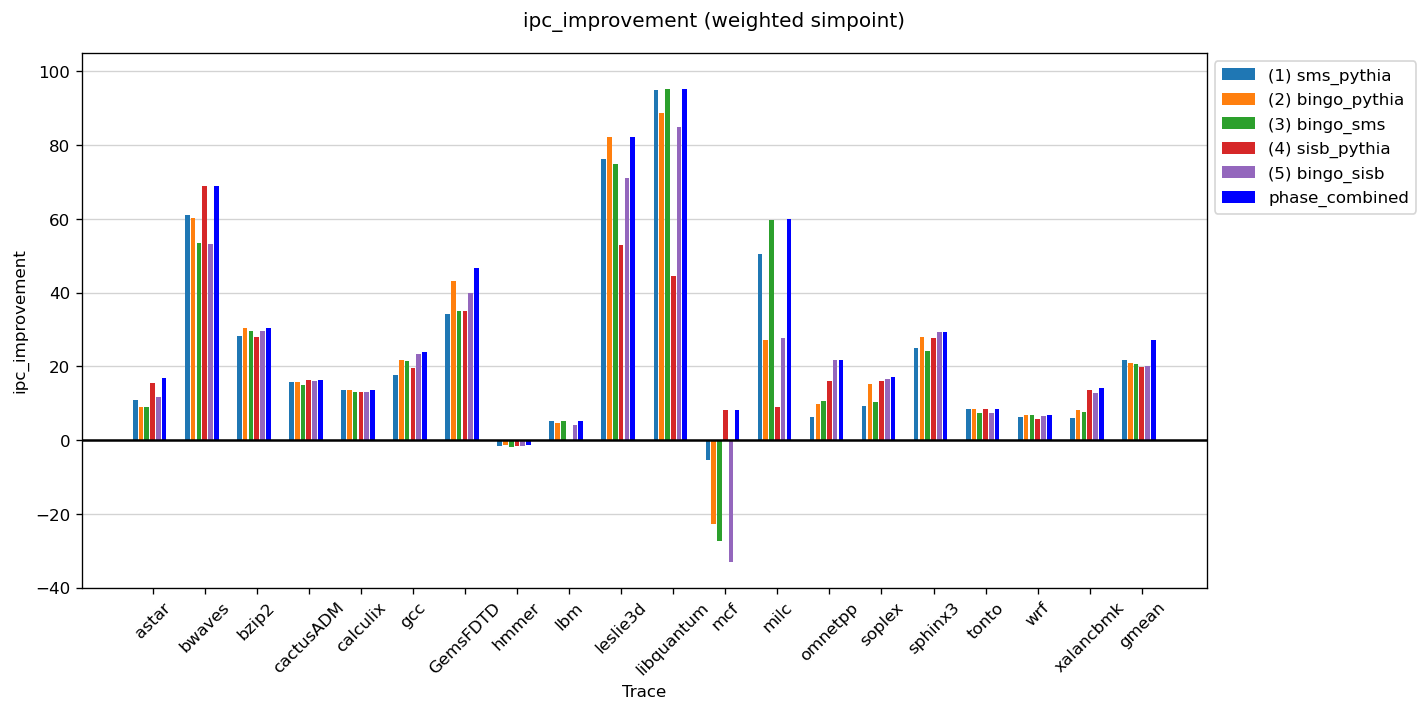

In [143]:
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                           ymin=-40, ymax=105, dpi=120,
                           filter_count=5,
                           filter_benchmarks=spec)
plt.savefig('ipc_improvement_5_spec.pdf')

### Weighted simpoint, all single prefetchers

/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


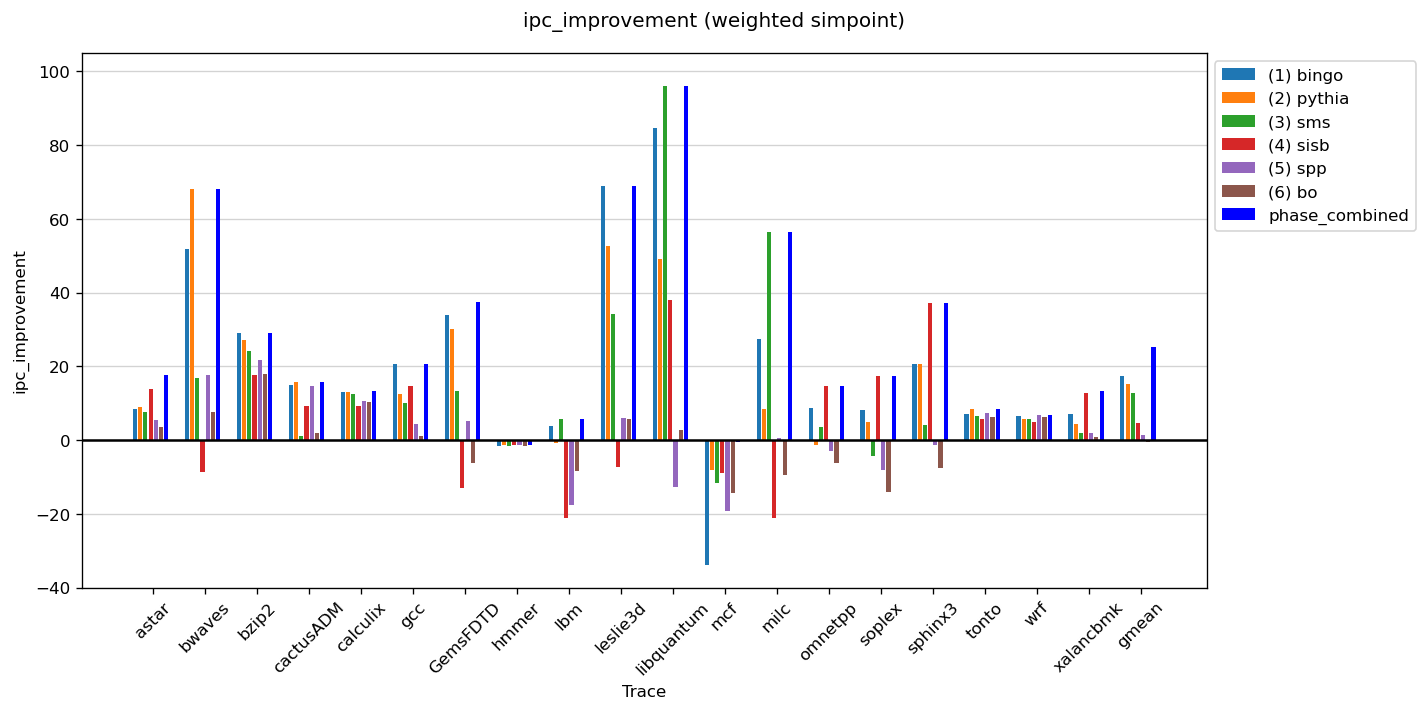

In [153]:
plot_cumulative_statistics(df[df.prefetcher.isin(['sisb', 'sms', 'bingo', 'bo', 'spp', 'pythia'])], 
                           weights, metric='ipc_improvement', method='weighted',
                           ymin=-40, ymax=105, dpi=120,
                           filter_benchmarks=spec)
plt.savefig('ipc_improvement_single_spec.pdf')

/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


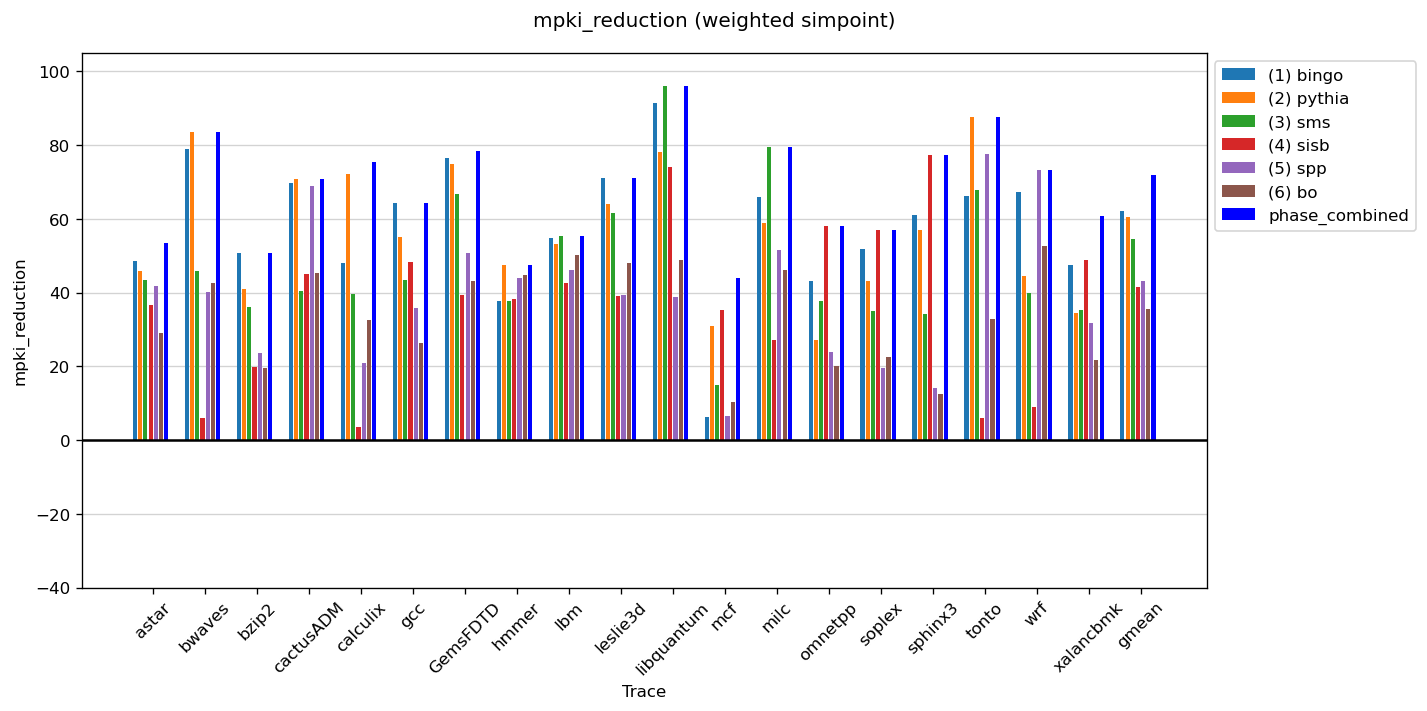

In [154]:
plot_cumulative_statistics(df[df.prefetcher.isin(['sisb', 'sms', 'bingo', 'bo', 'spp', 'pythia'])], 
                           weights, metric='mpki_reduction', method='weighted',
                           ymin=-40, ymax=105, dpi=120,
                           filter_benchmarks=spec)
plt.savefig('mpki_reduction_single_spec.pdf')

---
# GAP cumulative statistics

### Weighted simpoint, top 5

/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


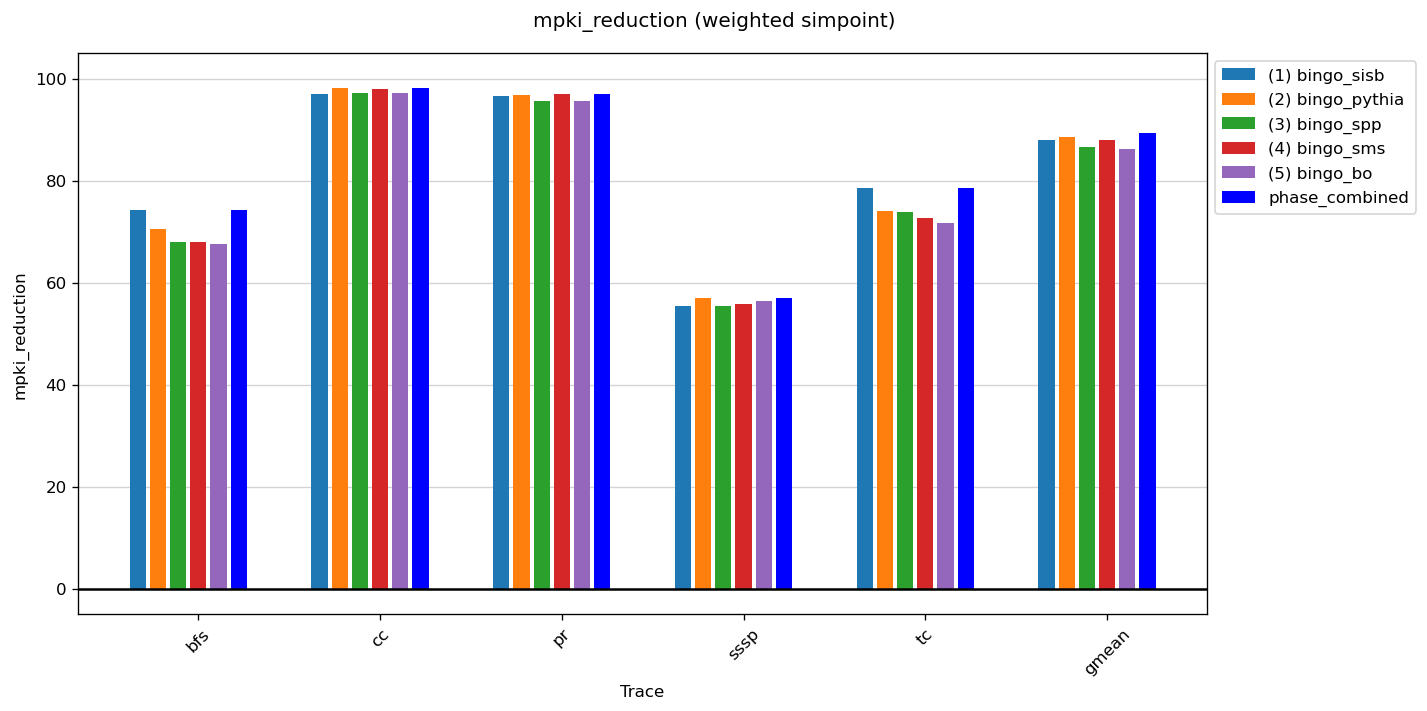

In [155]:
plot_cumulative_statistics(df, weights, metric='mpki_reduction', method='weighted',
                           ymin=-5, ymax=105, dpi=120,
                           filter_count=5,
                           filter_benchmarks=gap)
plt.savefig('mpki_reduction_5_gap.pdf')

/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


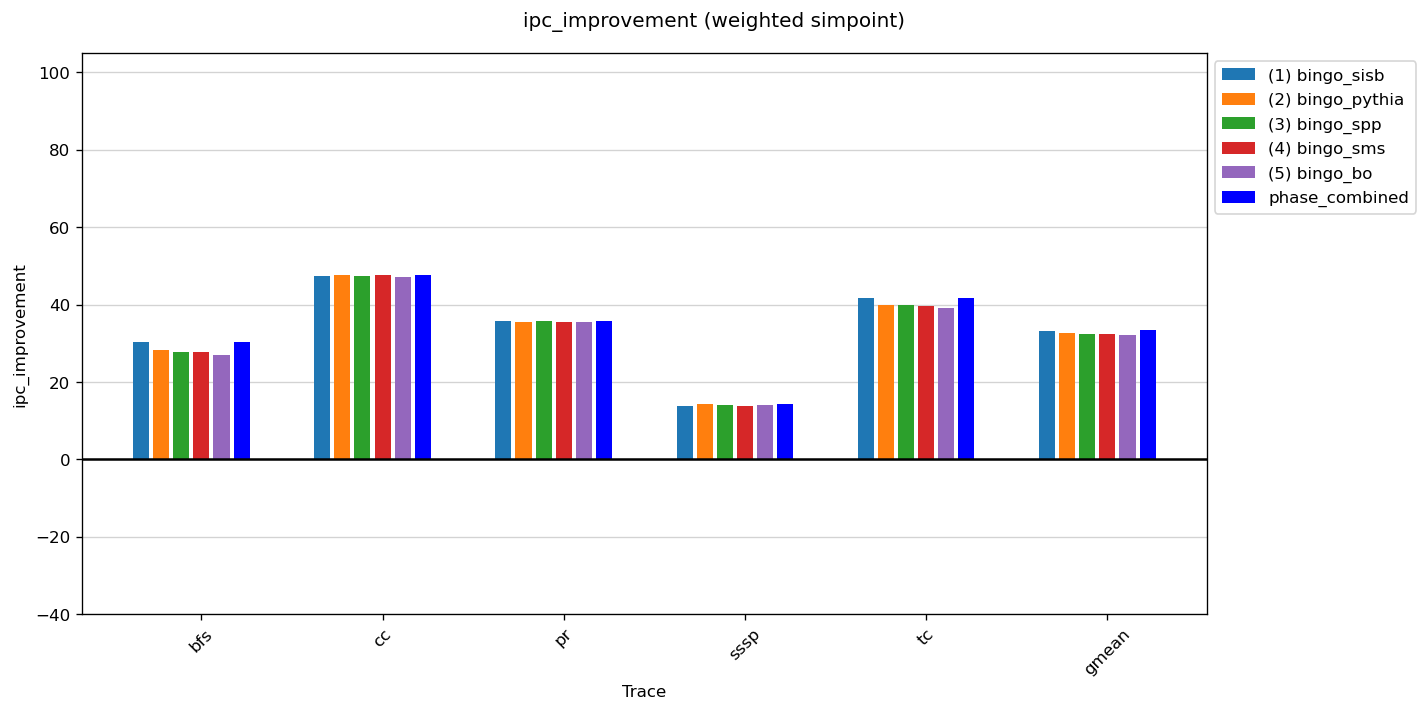

In [159]:
plot_cumulative_statistics(df, weights, metric='ipc_improvement', method='weighted',
                           ymin=-40, ymax=105, dpi=120,
                           filter_count=5,
                           filter_benchmarks=gap)
plt.savefig('ipc_improvement_5_gap.pdf')

### Weighted simpoint, all single prefetchers

/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


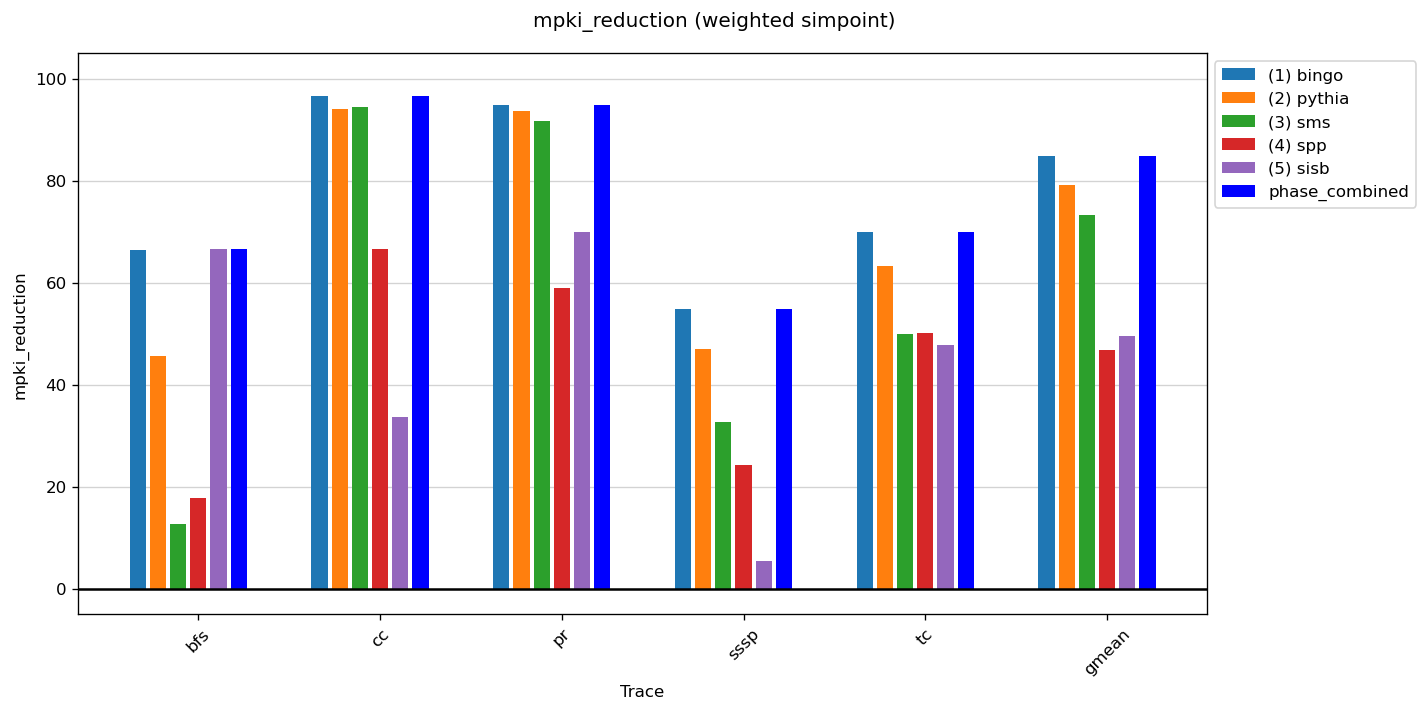

In [157]:
plot_cumulative_statistics(df[df.prefetcher.isin(['sisb', 'sms', 'bingo', 'bop', 'spp', 'pythia'])], 
                           weights, metric='mpki_reduction', method='weighted',
                           ymin=-5, ymax=105, dpi=120,
                           filter_benchmarks=gap)
plt.savefig('mpki_reduction_single_gap.pdf')

/u/cmolder/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


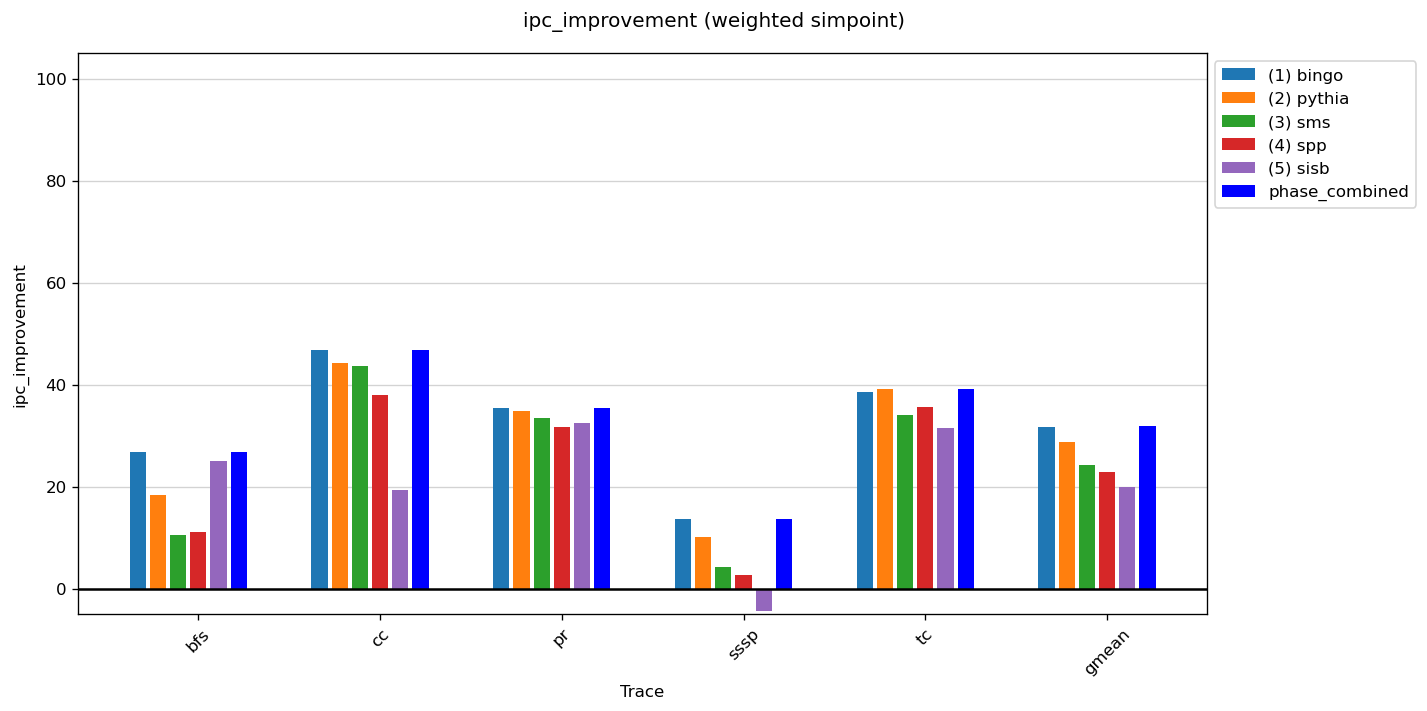

In [158]:
plot_cumulative_statistics(df[df.prefetcher.isin(['sisb', 'sms', 'bingo', 'bop', 'spp', 'pythia'])], 
                           weights, metric='ipc_improvement', method='weighted',
                           ymin=-5, ymax=105, dpi=120,
                           filter_benchmarks=gap)
plt.savefig('ipc_improvement_single_gap.pdf')

---
# Phase behvaior

In [150]:
def plot_phase_behavior(df, trace, metric, weights=None,
                        filter_by='ipc_improvement', filter_count=5,
                        ymin=None, ymax=None):
    
    if filter_by is not None:
        # Get best-performing prefetcher, by <filter-by>, on longest simpoints (same as above plots)
        longest_simpoints = get_longest_simpoints(weights)
        df_ = df[df.full_trace.isin(longest_simpoints)]
        best_prefetchers = get_best_prefetchers(df_, filter_by, filter_count)
    
    df = df[df.trace == trace][['simpoint', 'prefetcher', metric]]
    pf_list = best_prefetchers if filter_by is not None else df.prefetcher.unique()
    sp_list = df.simpoint.unique()
    if len(sp_list) <= 1: # Don't plot phase behavior on single-simpoint benchmarks (e.g. GAP)
        return
    
    # Plotting code is below.
    fig, ax = plt.subplots(dpi=120)
    ax.grid(axis='y', color='lightgray')
    ax.axhline(0, color='black')
    ax.set_axisbelow(True)
    
    for pf in pf_list:
        X, y = [], []
        for i, sp in enumerate(sp_list):
            X.append(i)
            y.append(df[(df.prefetcher == pf) & (df.simpoint == sp)][metric].item())
            
        if filter_by is not None:
            label = f'({best_prefetchers.index(pf)+1}) {pf}'
        else:
            label = pf
        
        ax.plot(X, y, '.-', label=label)

    # Get tick labels
    if not weights.empty:
        sp_labels = []
        for sp in sp_list:
            weight = weights[weights.trace == f'{trace}_{sp}'].weight.item()
            sp_labels.append(f'{sp} ({weight*100:.1f}%)')
    else:
        sp_labels = sp_list
    
    fig.suptitle(f'{trace}: {metric} phase behavior')
    ax.set_xticks(range(0, len(sp_list)))
    ax.set_xticklabels(sp_labels)
    ax.set_xlabel('Simpoint (weight)')
    ax.set_ylabel(metric)
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

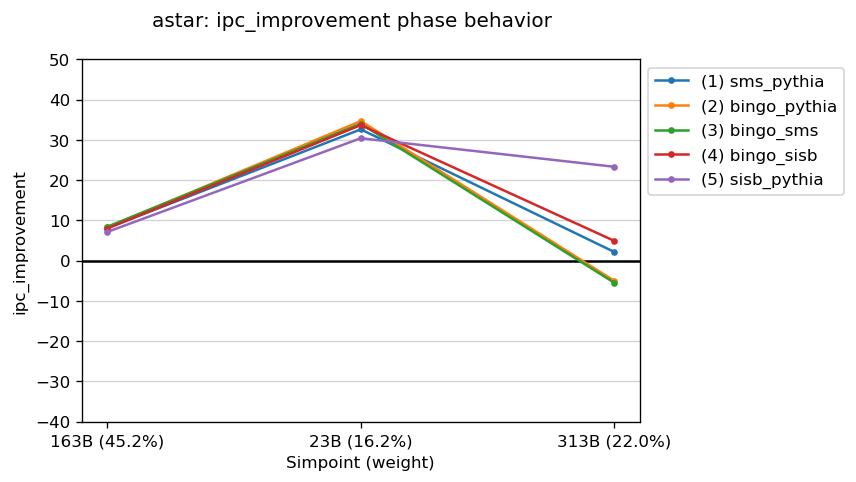

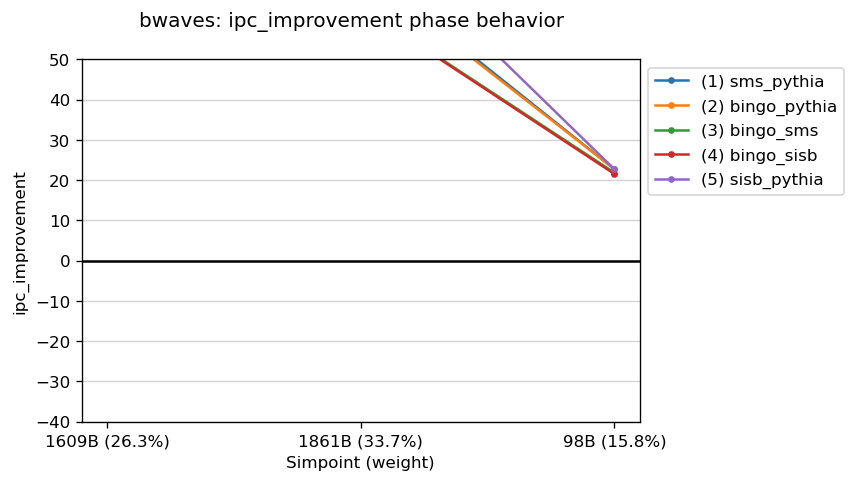

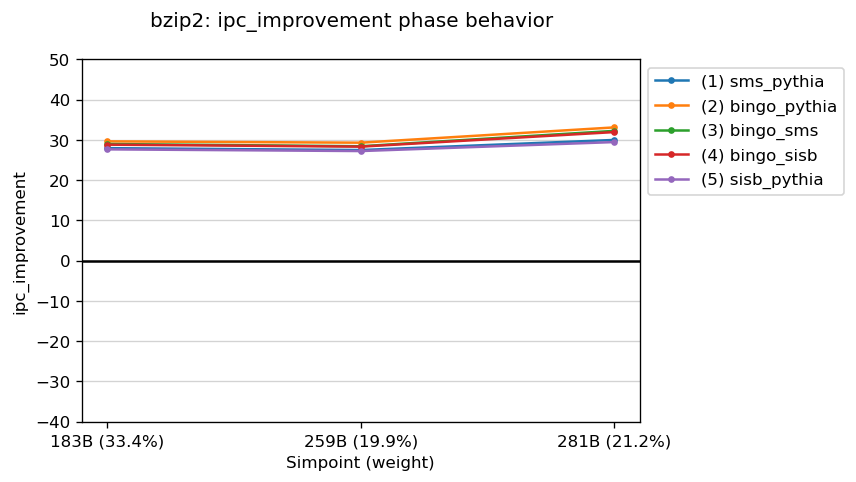

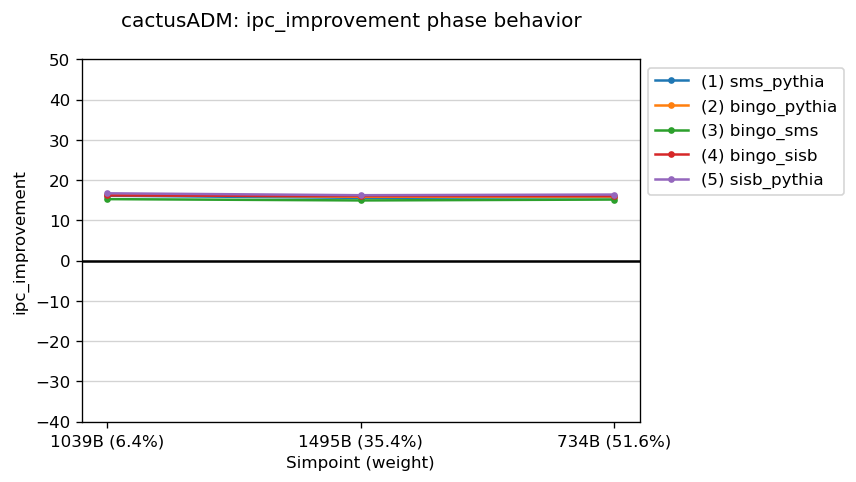

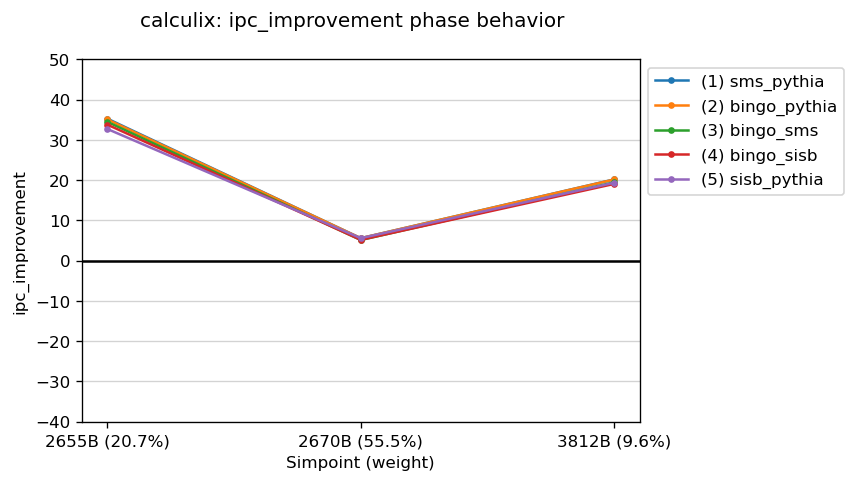

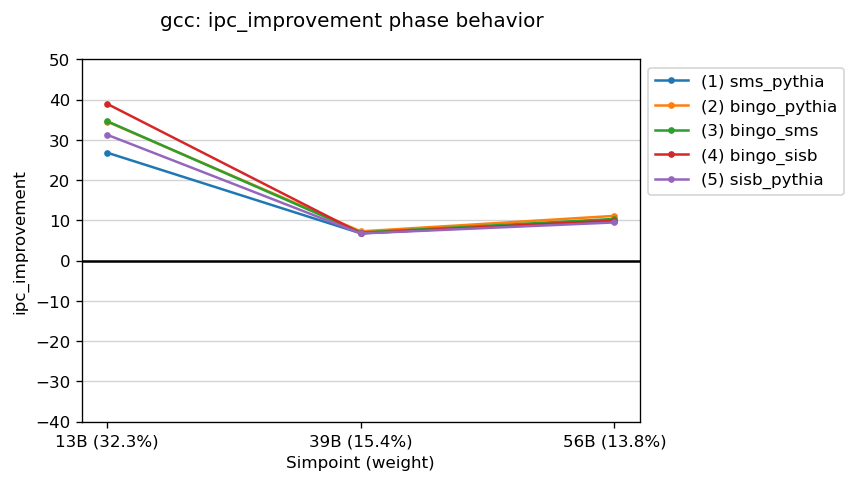

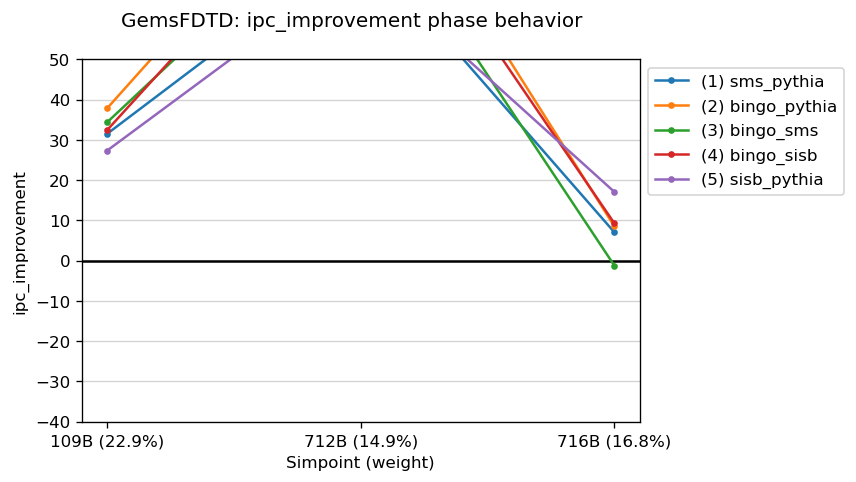

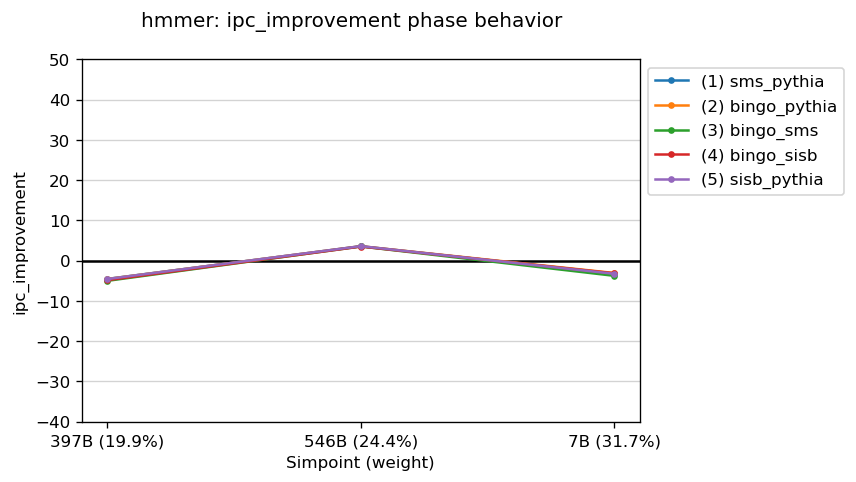

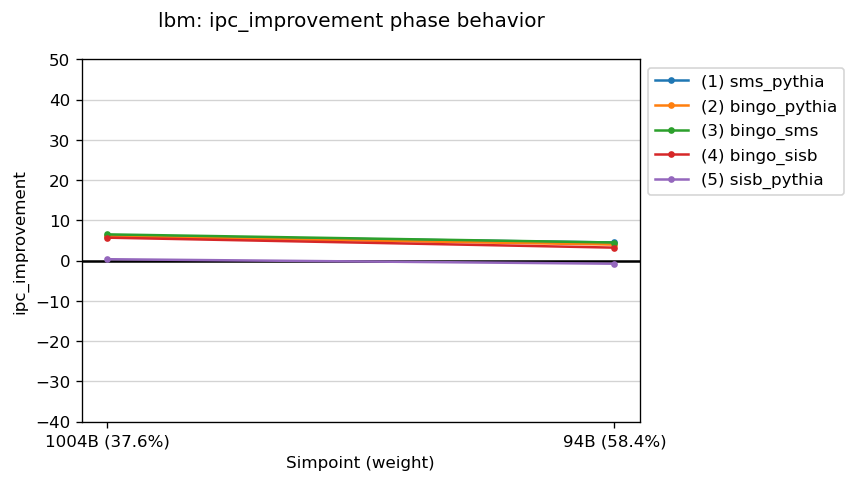

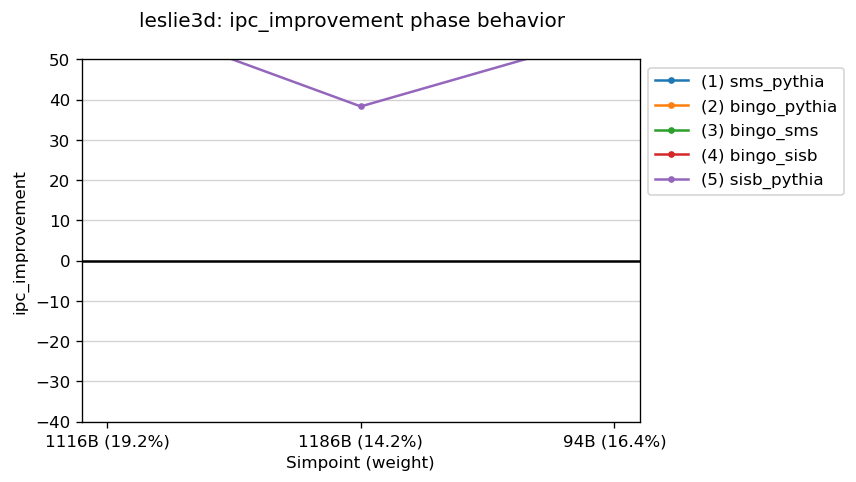

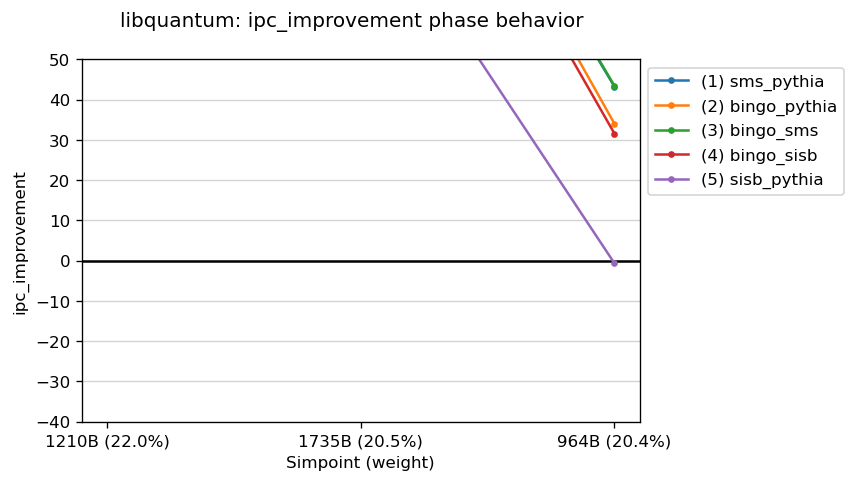

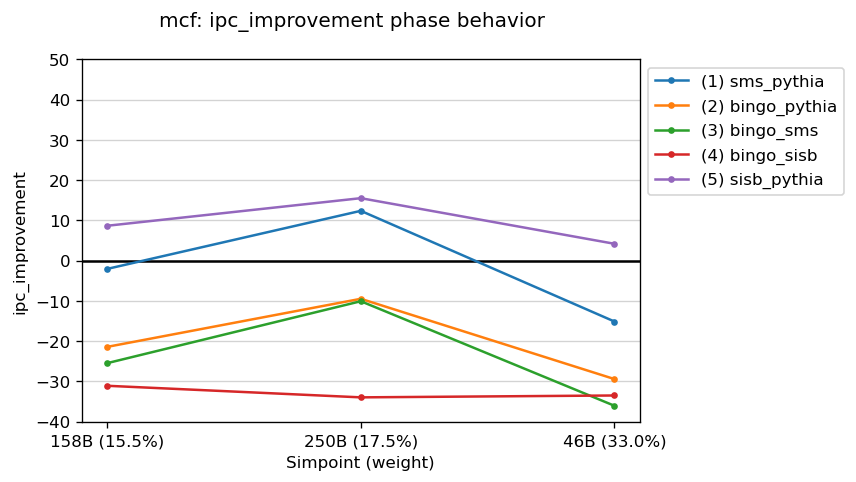

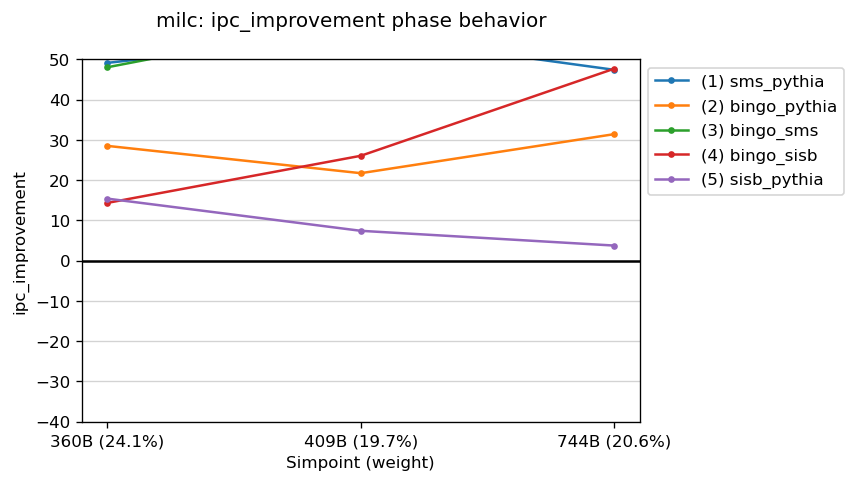

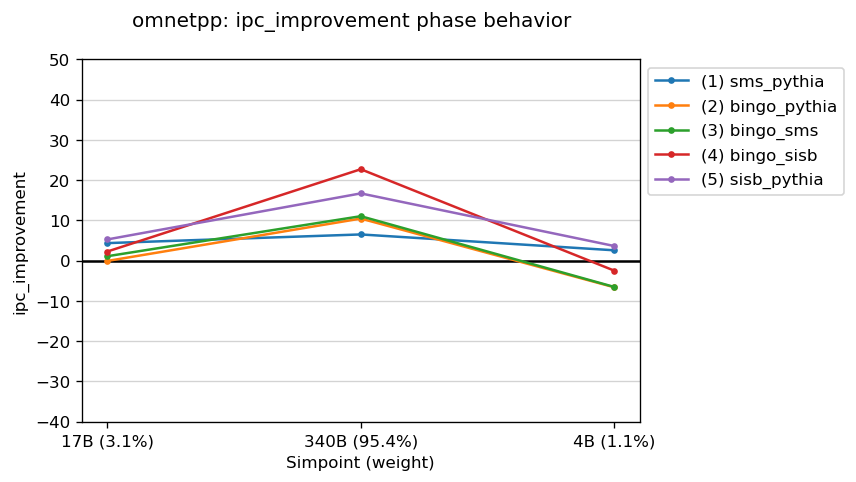

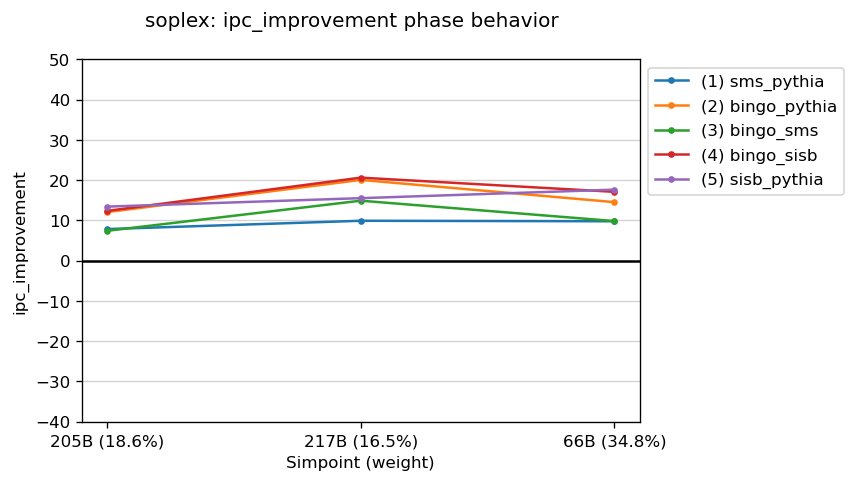

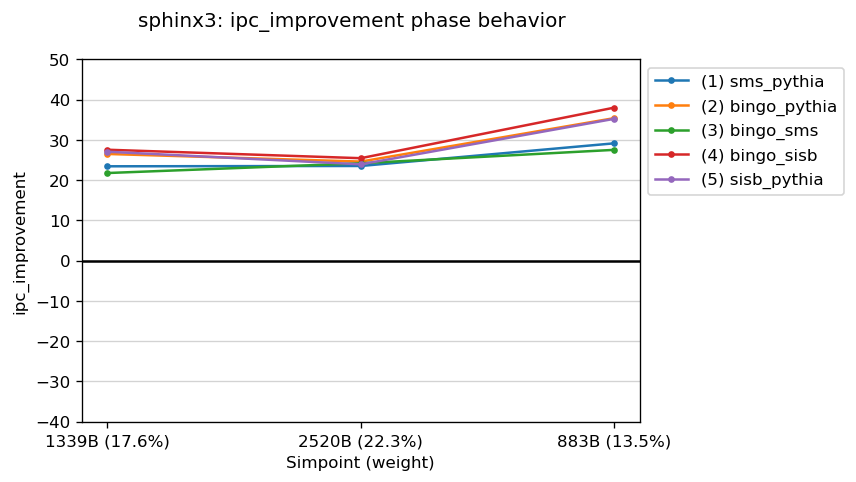

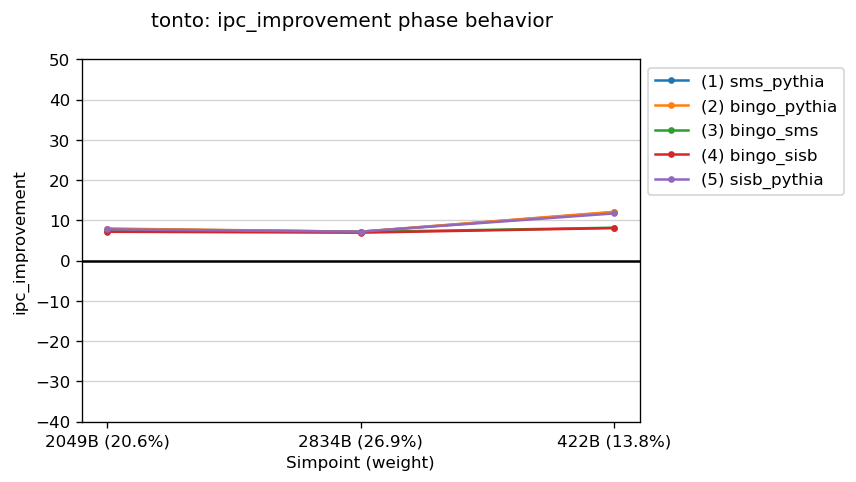

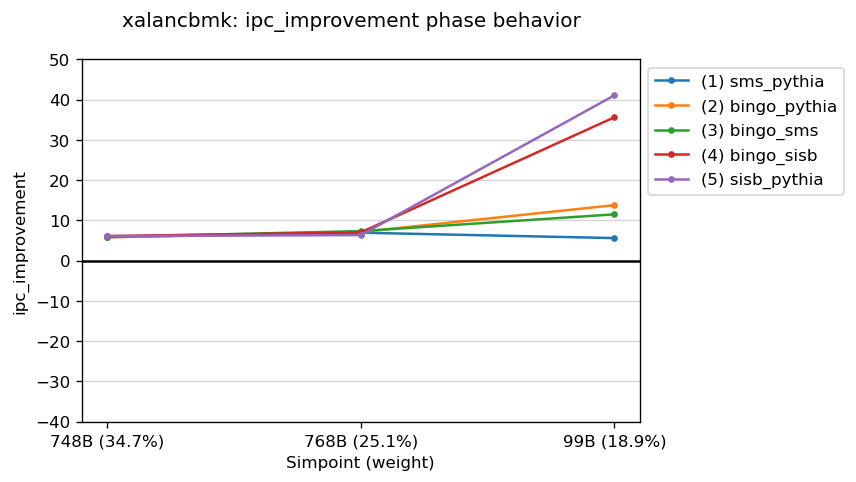

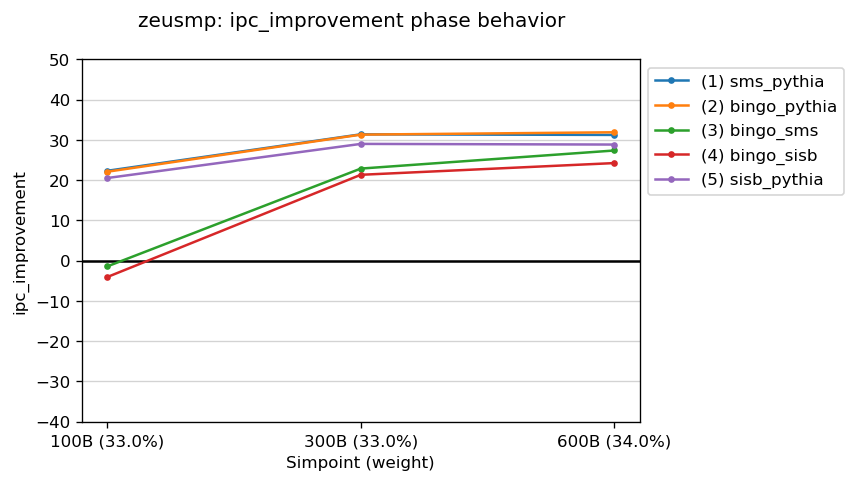

In [151]:
for tr in df.trace.unique():
    plot_phase_behavior(df, tr, 'ipc_improvement', weights=weights,
                        filter_count=5,
                        ymin=-40, ymax=50)

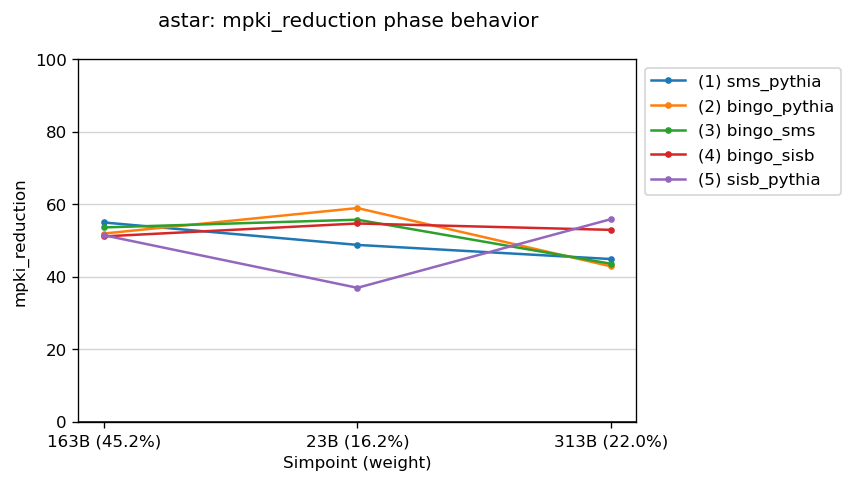

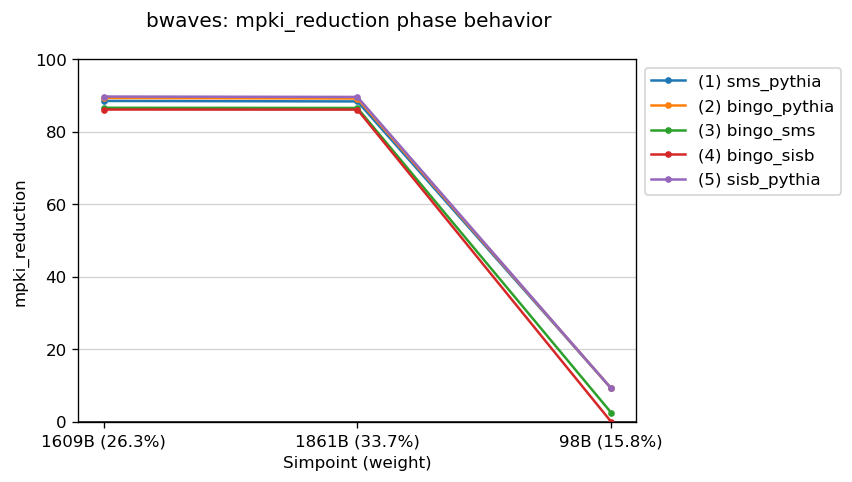

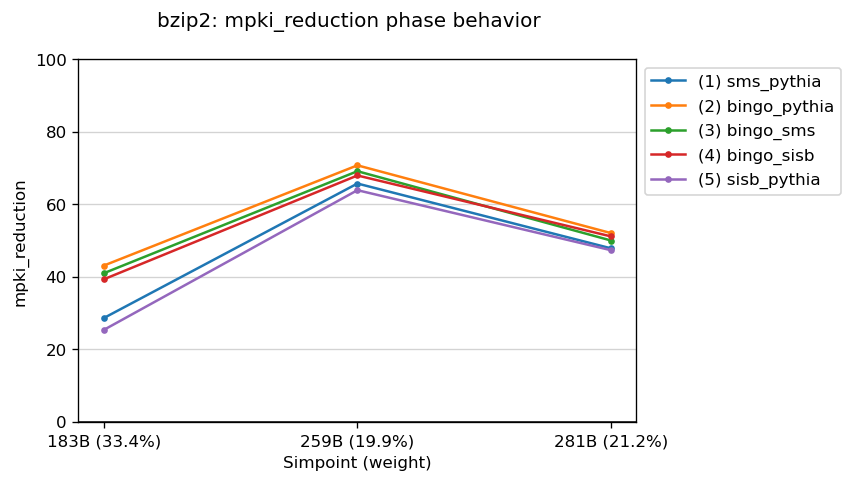

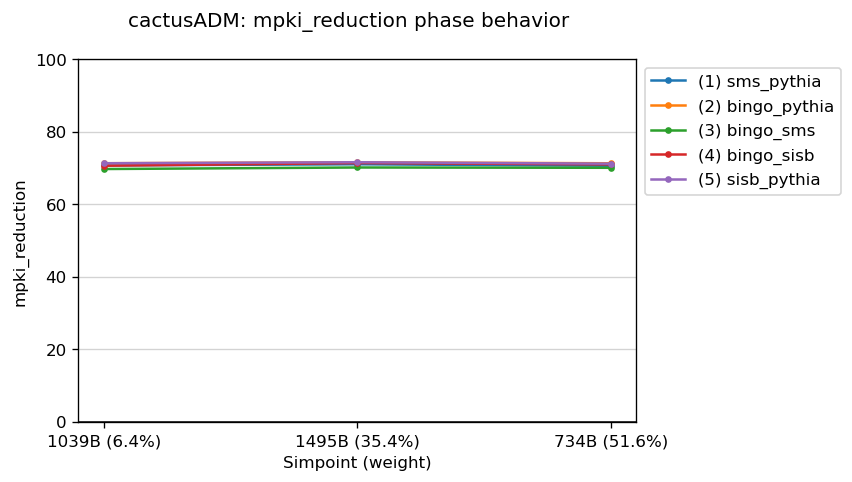

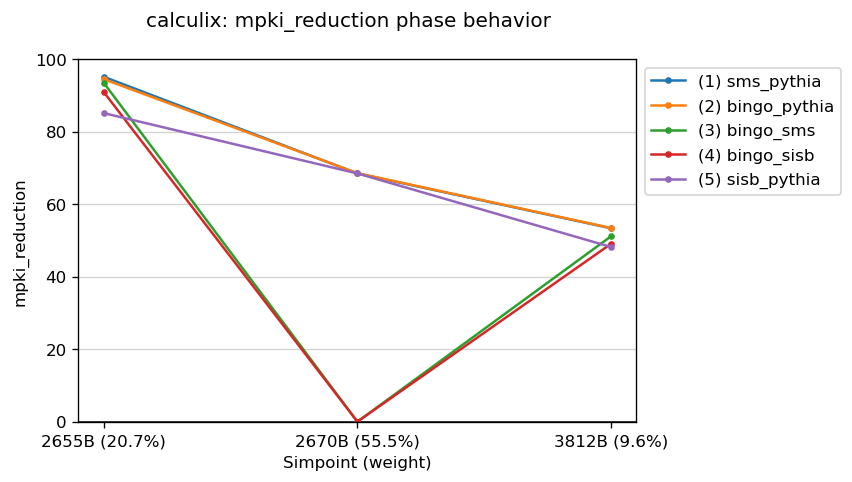

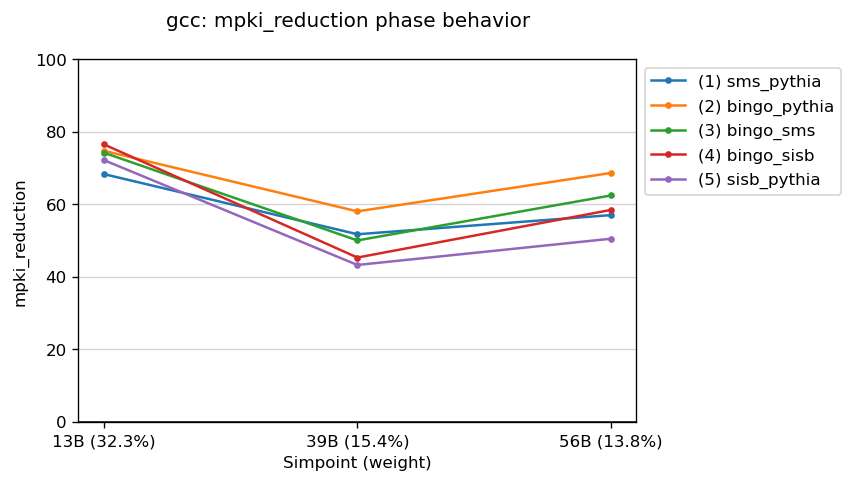

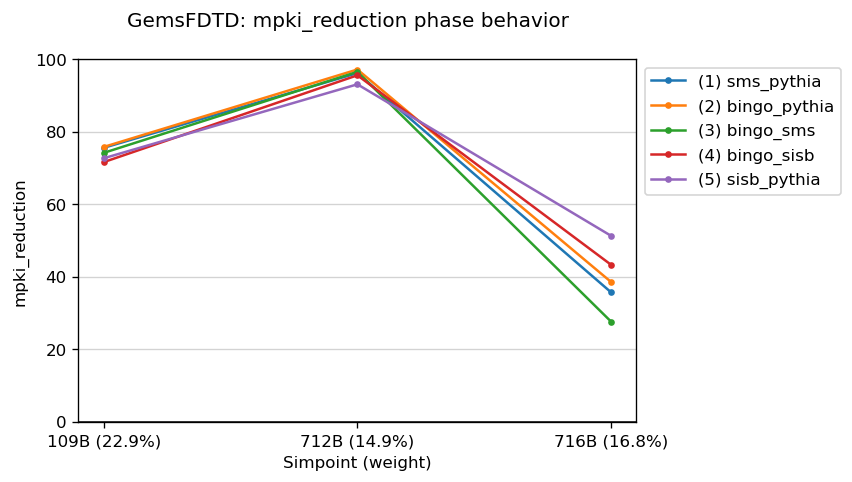

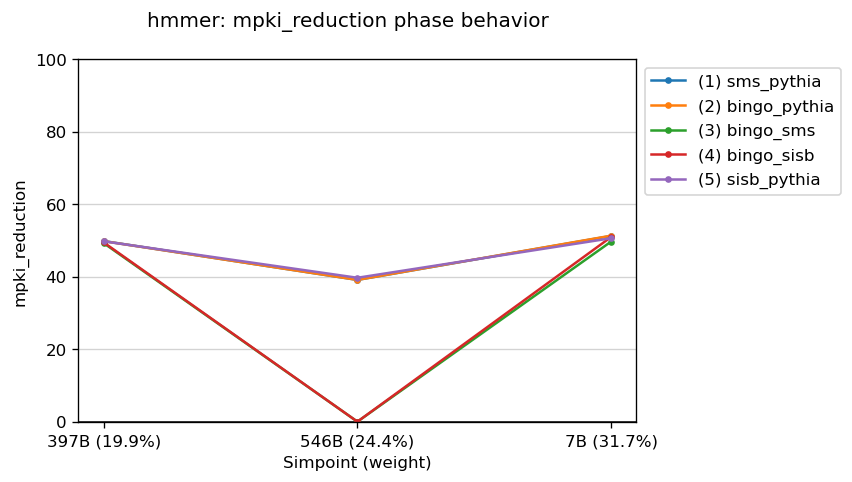

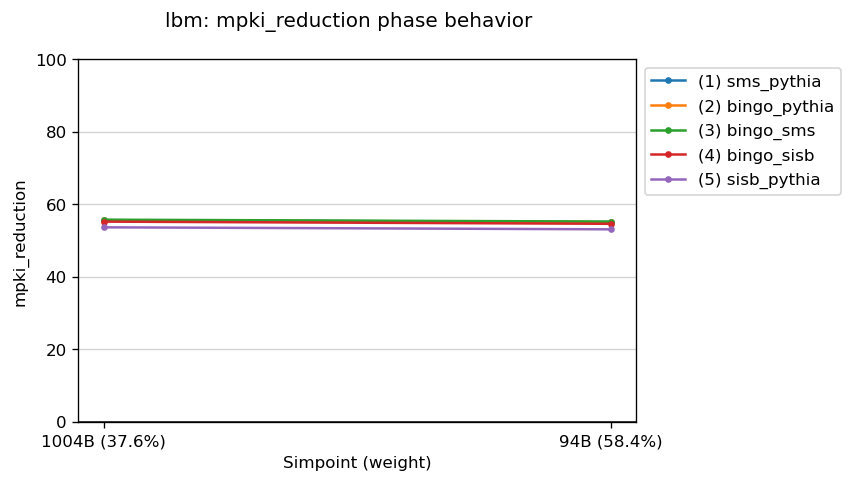

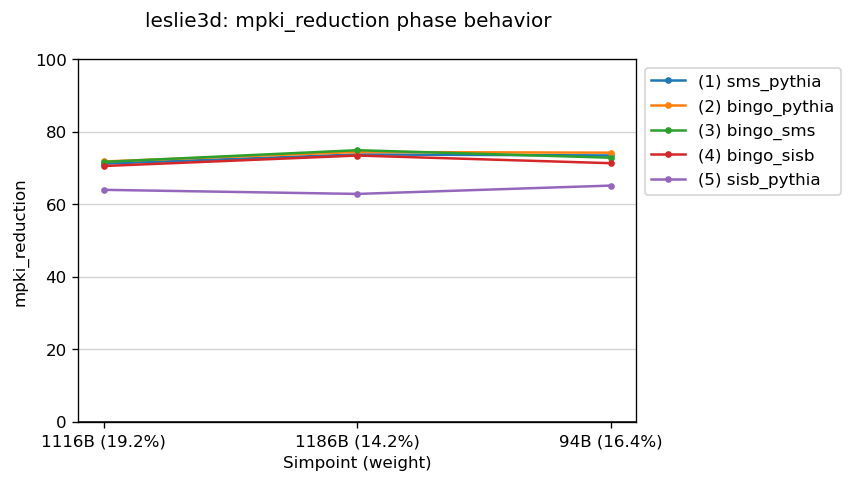

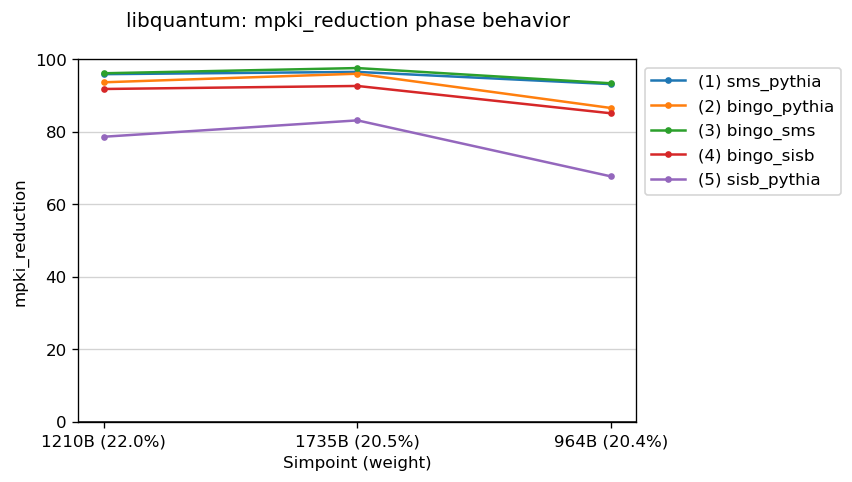

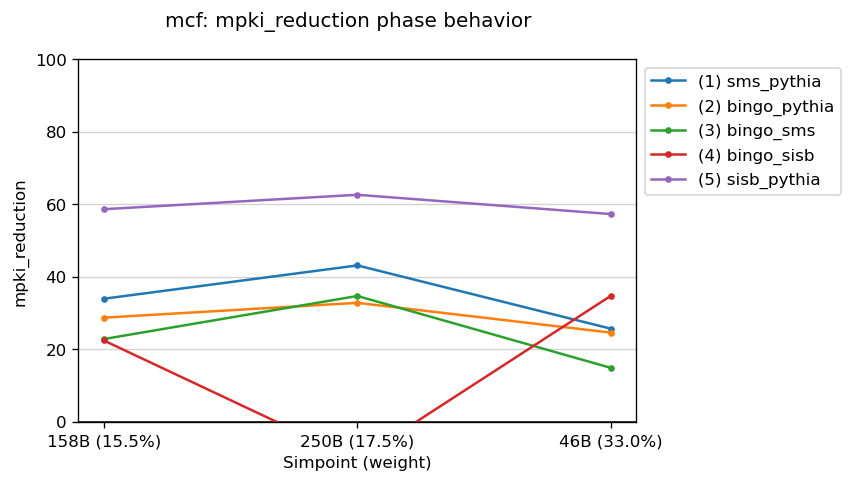

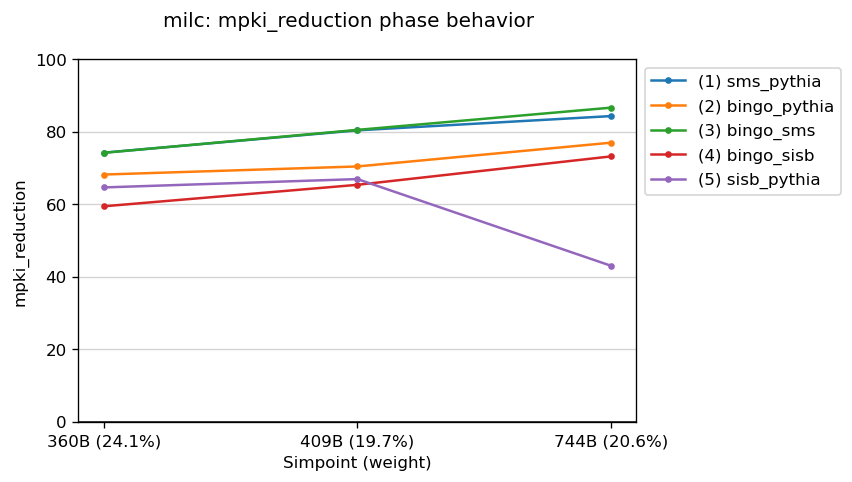

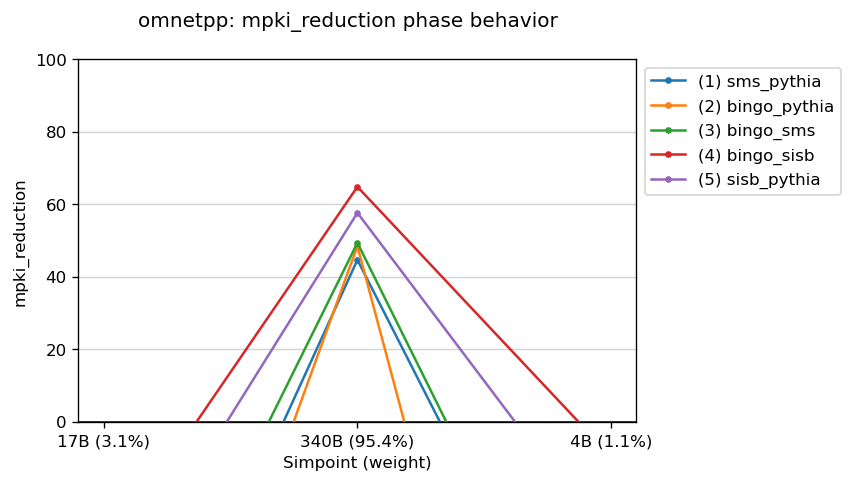

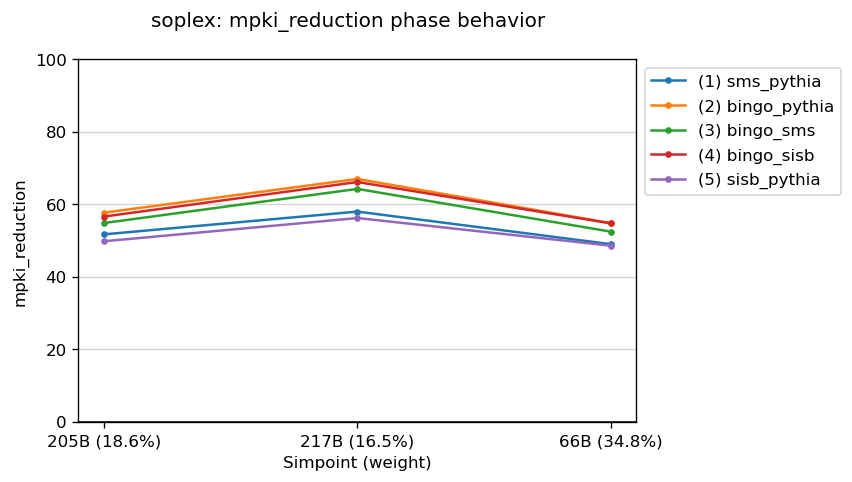

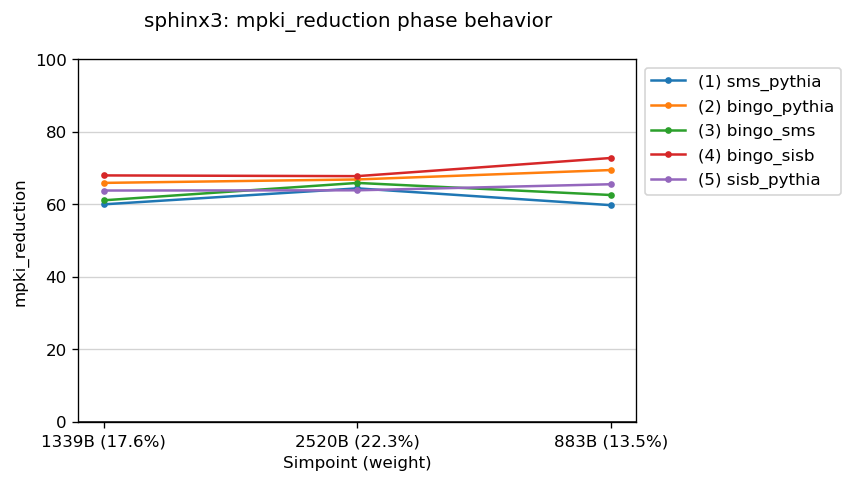

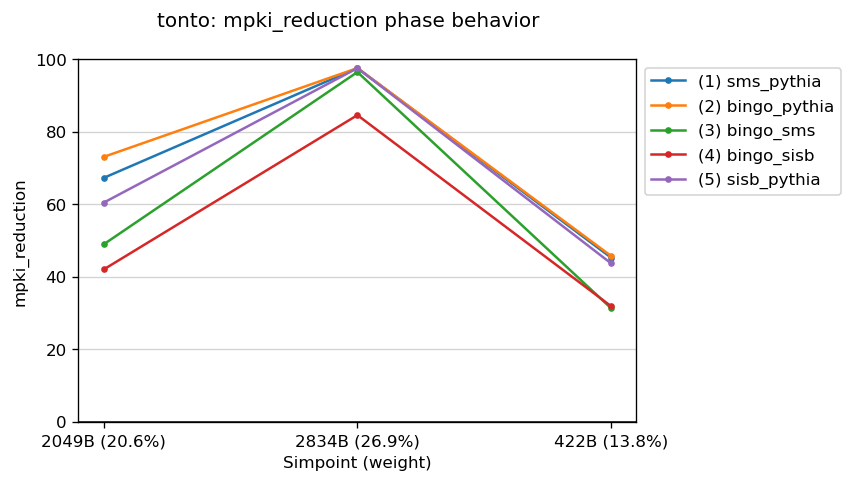

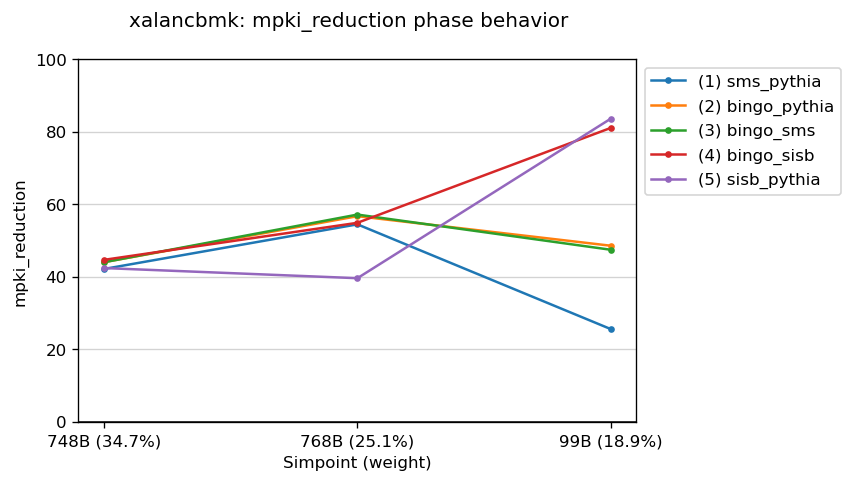

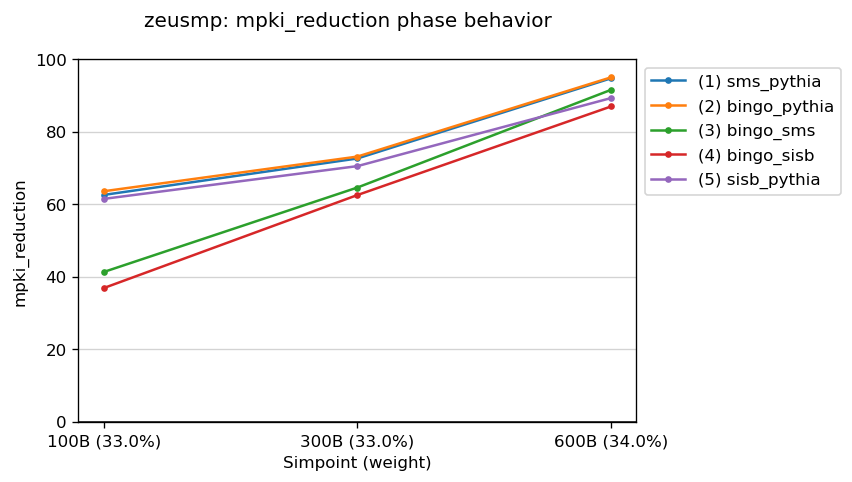

In [152]:
for tr in df.trace.unique():
    plot_phase_behavior(df, tr, 'mpki_reduction', weights=weights, 
                        ymin=0, ymax=100)